In [35]:
from sklearn.neighbors import KNeighborsClassifier,RadiusNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from scipy.io import loadmat
from sklearn.model_selection import train_test_split                 
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from __future__ import print_function
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.datasets import imdb
from sklearn import preprocessing   
from sklearn.metrics import accuracy_score,roc_auc_score,auc,confusion_matrix,roc_curve
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau
from imblearn.over_sampling import RandomOverSampler,SMOTE,SMOTENC,ADASYN,BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler

In [36]:
m = loadmat("FTD_90_200_fMRI.mat") 

In [37]:
min_max_scaler = preprocessing.MinMaxScaler()
FTD=np.zeros((m['FTD'].shape[0],90,200))
for i in range(m['FTD'].shape[0]):
    FTD[i]= min_max_scaler.fit_transform(m['FTD'][i][:,0:200])
    #FTD[i]= m['FTD'][i][:,0:200]
    #FTD[i]= preprocessing.scale(m['FTD'][i][:,20:180], axis=0)
NC=np.zeros((m['NC'].shape[0],90,200))
for i in range(m['NC'].shape[0]):
    NC[i]= min_max_scaler.fit_transform(m['NC'][i][:,0:200])
    #NC[i]= m['NC'][i][:,0:200]
    #NC[i]= preprocessing.scale(m['NC'][i][:,20:180], axis=0)

In [38]:
label_FTD = [0]*m['FTD'].shape[0]
label_NC = [1]*m['NC'].shape[0]
FTD = FTD.tolist()
NC = NC.tolist()
df = FTD + NC
label = label_FTD + label_NC
df = np.array(df)
print(df.shape)
label = np.array(label)
FTD = np.array(FTD)
dataset=FTD
print(FTD.shape)
NC = np.array(NC)
label_AD=np.array(label_FTD)
label_NC=np.array(label_NC)

(181, 90, 200)
(95, 90, 200)


D:\Anaconda\envs\lab\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Anaconda\envs\lab\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


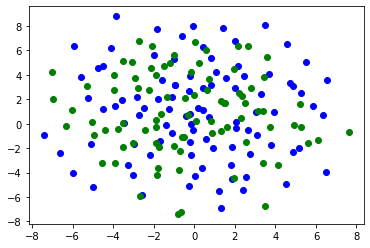

In [39]:
tsne = TSNE(n_components=2)#tsne降维
#pca = PCA(n_components=10)
tsne_df=tsne.fit_transform(df.reshape(df.shape[0],-1))
#pca_df=pca.fit_transform(df.reshape(df.shape[0],-1))
#print(tsne_df[:374,0])
plt.scatter(tsne_df[:95,0],tsne_df[:95,1],c='b')
#plt.scatter(tsne_df[1][0],tsne_df[1][1],c='b')
#plt.scatter(tsne_df[2][0],tsne_df[2][1],c='b')
#plt.scatter(tsne_df[3][0],tsne_df[3][1],c='b')
#plt.scatter(tsne_df[4][0],tsne_df[4][1],c='b')
plt.scatter(tsne_df[95:,0],tsne_df[95:,1],c='g')
plt.show()

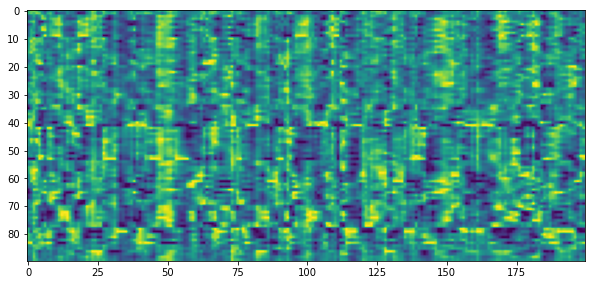

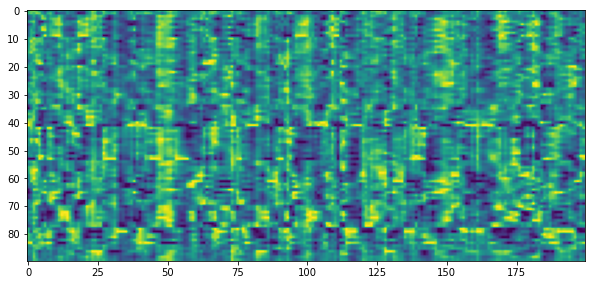

In [40]:
fig = plt.figure(figsize=(10,10), facecolor='w', edgecolor='k')
plt.imshow(min_max_scaler.fit_transform(df[0]))
plt.show()
fig = plt.figure(figsize=(10,10), facecolor='w', edgecolor='k')
plt.imshow(df[0])
plt.show()

In [41]:
x_train,x_test,y_train,y_test = train_test_split(df , label, test_size = 0.1)  

In [42]:
def progress(data):
    data = data[:,15:]
    #print(data.shape)
    data = np.corrcoef(data)
    data = np.tril(data)
    len = data.shape[0]
    new_data = []
    for i in range(len):
        for j in range(i):
            new_data.append(data[i, j])
    data = np.asarray([new_data])
    data = data.astype(np.float32)
    return data

In [43]:
train_dataset=np.zeros((x_train.shape[0],4005))
for i in range(x_train.shape[0]):
    train_dataset[i]=progress(x_train[i])
    #train_dataset[i][np.where(train_dataset[i]<train_dataset[i].mean())]=0
test_dataset=np.zeros((x_test.shape[0],4005))
for i in range(x_test.shape[0]):
    #print(x_test[i].shape)
    test_dataset[i]=progress(x_test[i])
    #test_dataset[i][np.where(test_dataset[i]<test_dataset[i].mean())]=0

In [44]:
class GetLoader(torch.utils.data.Dataset):

    def __init__(self, data_root, data_label):
        self.data = data_root
        self.label = data_label

    # index是根据batchsize划分数据后得到的索引，最后将data和对应的labels进行一起返回
    def __getitem__(self, index):
        #print(np.array(self.data).shape)
        #print(index)
        #print(np.array(self.label).shape)
        data = self.data[index]
        labels = self.label[index]
        return data, labels

    # 该函数返回数据大小长度，目的是DataLoader方便划分，如果不知道大小，DataLoader会一脸懵逼
    def __len__(self):
        return len(self.data)

In [45]:
def model_train_test(this_train_x,this_train_y,this_test_x,this_test_y):
    train_dataset=np.zeros((this_train_x.shape[0],4005))
    for i in range(this_train_x.shape[0]):
        train_dataset[i]=progress(this_train_x[i])
        #train_dataset[i][np.where(train_dataset[i]<train_dataset[i].mean())]=train_dataset[i].mean()
    test_dataset=np.zeros((this_test_x.shape[0],4005))
    for i in range(this_test_x.shape[0]):
        #print(x_test[i].shape)
        test_dataset[i]=progress(this_test_x[i])
        #test_dataset[i][np.where(test_dataset[i]<test_dataset[i].mean())]=test_dataset[i].mean()
    
    acc_total_train = 0
    acc_total_test = 0
    #print(train_dataset.shape)
    model = SVC(C=1,kernel='poly', degree=2)
    ros=RandomOverSampler(random_state=0) #采用随机过采样（上采样）
    rus=RandomUnderSampler(random_state=0,replacement=True) #采用随机欠采样（下采样）
    #train_dataset,this_train_y=ros.fit_resample(train_dataset,this_train_y)
    #train_dataset,this_train_y=rus.fit_resample(train_dataset,this_train_y)
    #print(train_dataset.shape)
    #model = RandomForestClassifier(random_state=0,n_estimators=10,max_features=10)
    #model = KNeighborsClassifier(n_neighbors=2, weights='uniform')
    model.fit(train_dataset, this_train_y)

    pred = model.predict(train_dataset)
    acc = accuracy_score(this_train_y, pred)
    acc_total_train += acc
    fpr_train,tpr_train,threshold_train = roc_curve(this_train_y, pred) 
    roc_auc_train = auc(fpr_train,tpr_train)
    pred = model.predict(test_dataset)
    acc = accuracy_score(this_test_y, pred)
    fpr,tpr,threshold = roc_curve(this_test_y, pred) 
    roc_auc = auc(fpr,tpr)
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='test ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.plot(fpr_train, tpr_train, color='red',
         lw=lw, label='train ROC curve (area = %0.2f)' % roc_auc_train) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    if(len(set(this_test_y))!=1):
        roc=roc_auc_score(this_test_y, pred)
        sensitivity=confusion_matrix(this_test_y, pred)[0][0]/(confusion_matrix(this_test_y, pred)[0][0]+confusion_matrix(this_test_y, pred)[0][1])
        specificity=confusion_matrix(this_test_y, pred)[1][1]/(confusion_matrix(this_test_y, pred)[1][1]+confusion_matrix(this_test_y, pred)[1][0])
    else:
        roc=0
        sensitivity=0
        specificity=0
    acc_total_test += acc
    print('\n 训练集',acc_total_train, '测试集', acc_total_test)
    return acc_total_test,acc_total_train,roc,sensitivity,specificity

In [46]:
def kfold_train_test(n):
    from sklearn.model_selection import KFold
    accuracy = list()   
    train_accuracy = [] 
    roc_all=[]
    sensitivity_all=[]
    specificity_all=[]
    k =10    #10折交叉验证重复k次
    for i in range(k):
        kfold = KFold(n_splits=n,shuffle=True)
        for train_index, test_index in kfold.split(df, label):
            # train_index 就是分类的训练集的下标，test_index 就是分配的验证集的下标
            this_train_x, this_train_y = df[train_index], label[train_index]  # 本组训练集
            this_test_x, this_test_y = df[test_index], label[test_index]  # 本组验证集
            # 训练本组的数据，并计算准确率
            acc,train_acc,roc,sensitivity,specificity=model_train_test(this_train_x,this_train_y,this_test_x,this_test_y)
            accuracy.append(acc)
            train_accuracy.append(train_acc)
            print('roc:',roc)
            print('sensitivity:',sensitivity)
            print('specificity:',specificity)
            roc_all.append(roc)
            sensitivity_all.append(sensitivity)
            specificity_all.append(specificity)
            #print(accuracy)  # 得到预测结果区间[0,1]
    roc_all=np.array(roc_all)
    roc_all=roc_all[np.nonzero(roc_all)]
    sensitivity_all=np.array(sensitivity_all)
    sensitivity_all=sensitivity_all[np.nonzero(sensitivity_all)]
    specificity_all=np.array(specificity_all)
    specificity_all=specificity_all[np.nonzero(specificity_all)]
    print('average test accuracy:',np.array(accuracy).sum()/(k*n))
    print('average train accuracy:',np.array(train_accuracy).sum()/(k*n))
    print('average roc:',np.array(roc_all).sum()/np.array(roc_all).shape[0])
    print('average sensitivity:',np.array(sensitivity_all).sum()/np.array(sensitivity_all).shape[0])
    print('average specificity:',np.array(specificity_all).sum()/np.array(specificity_all).shape[0])
    plt.plot(np.array(accuracy))
    plt.plot(np.array(train_accuracy))

<Figure size 432x288 with 0 Axes>

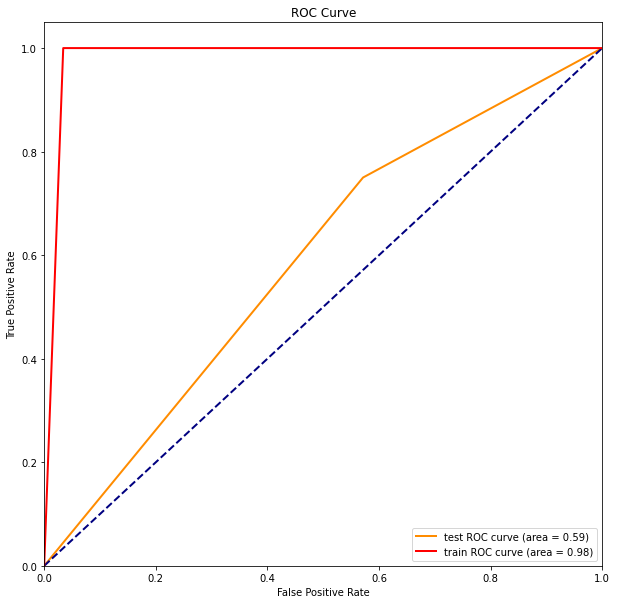


 训练集 0.9814814814814815 测试集 0.631578947368421
roc: 0.5892857142857143
sensitivity: 0.42857142857142855
specificity: 0.75


<Figure size 432x288 with 0 Axes>

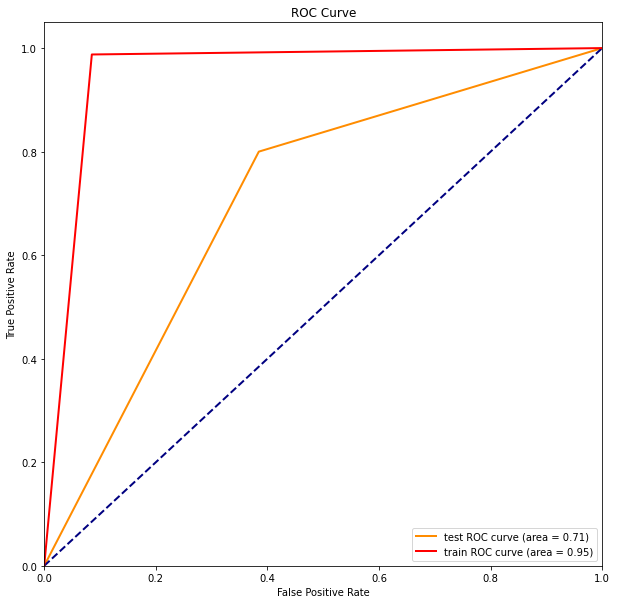


 训练集 0.950920245398773 测试集 0.6666666666666666
roc: 0.7076923076923077
sensitivity: 0.6153846153846154
specificity: 0.8


<Figure size 432x288 with 0 Axes>

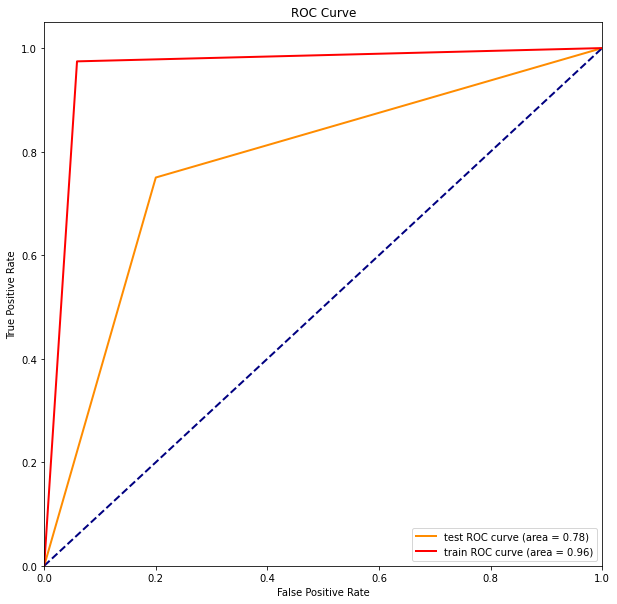


 训练集 0.9570552147239264 测试集 0.7777777777777778
roc: 0.7750000000000001
sensitivity: 0.8
specificity: 0.75


<Figure size 432x288 with 0 Axes>

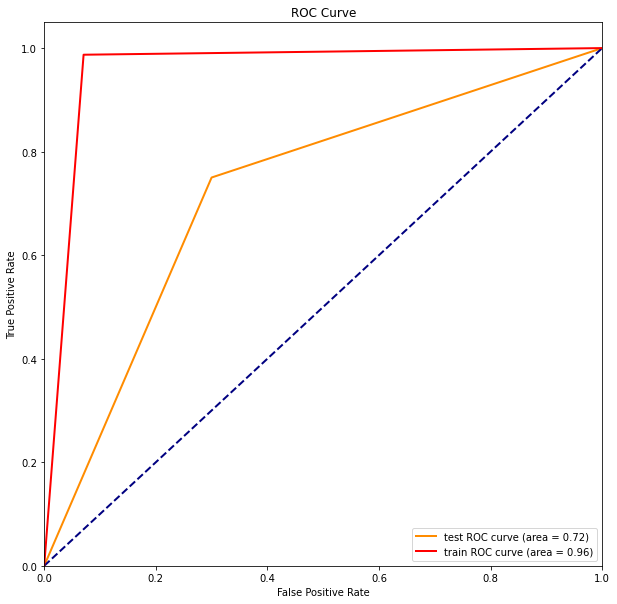


 训练集 0.9570552147239264 测试集 0.7222222222222222
roc: 0.7249999999999999
sensitivity: 0.7
specificity: 0.75


<Figure size 432x288 with 0 Axes>

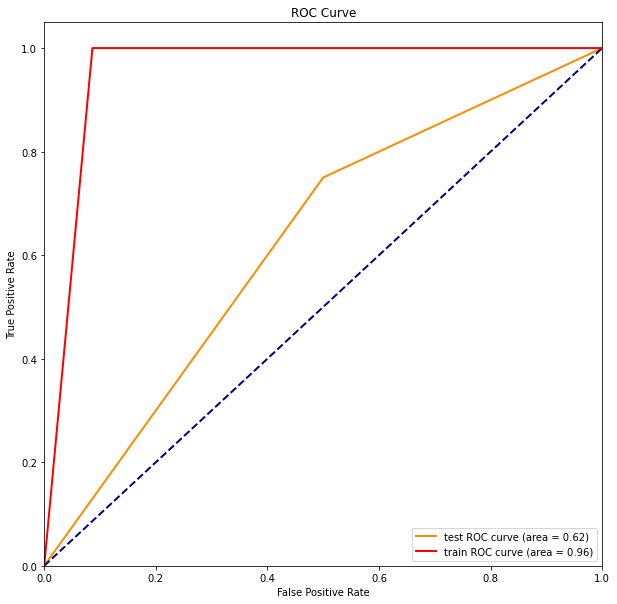


 训练集 0.9570552147239264 测试集 0.5555555555555556
roc: 0.625
sensitivity: 0.5
specificity: 0.75


<Figure size 432x288 with 0 Axes>

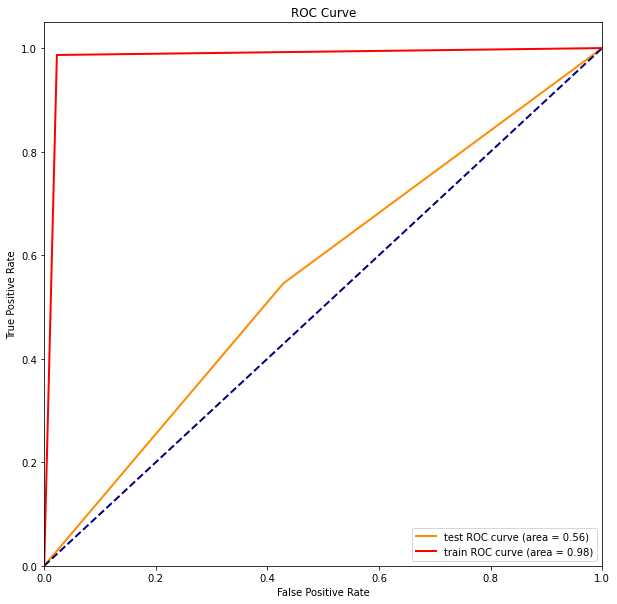


 训练集 0.9815950920245399 测试集 0.5555555555555556
roc: 0.5584415584415584
sensitivity: 0.5714285714285714
specificity: 0.5454545454545454


<Figure size 432x288 with 0 Axes>

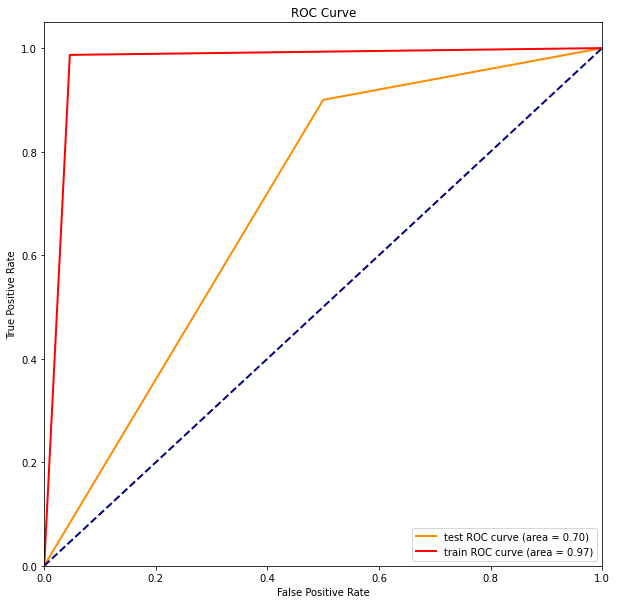


 训练集 0.9693251533742331 测试集 0.7222222222222222
roc: 0.7
sensitivity: 0.5
specificity: 0.9


<Figure size 432x288 with 0 Axes>

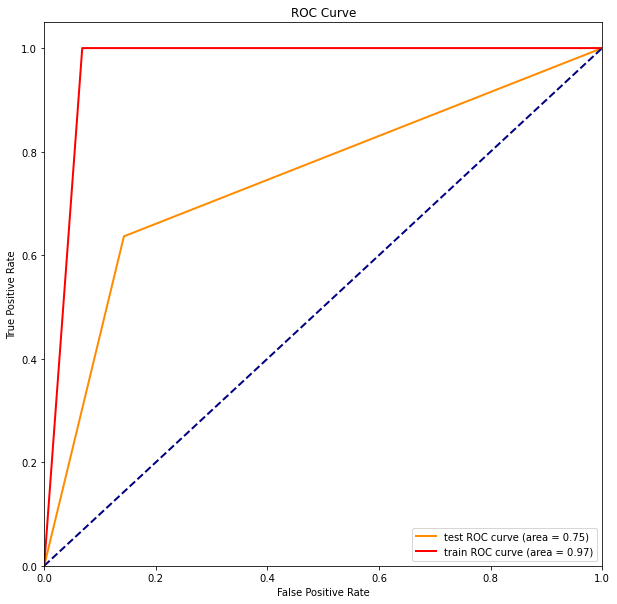


 训练集 0.9631901840490797 测试集 0.7222222222222222
roc: 0.7467532467532467
sensitivity: 0.8571428571428571
specificity: 0.6363636363636364


<Figure size 432x288 with 0 Axes>

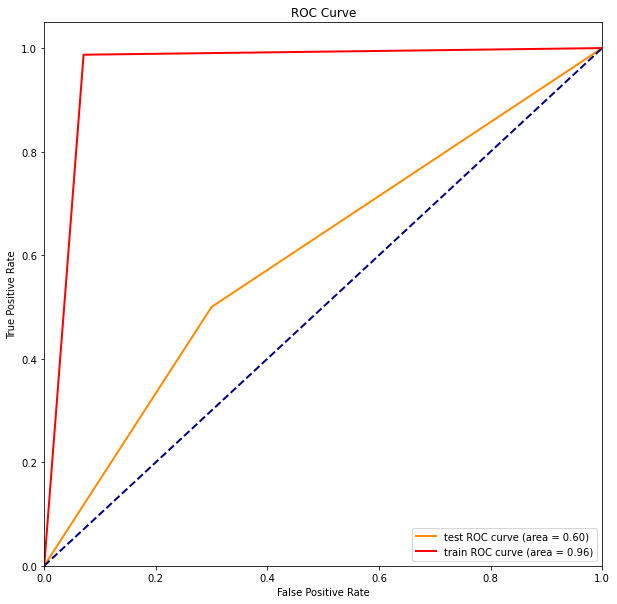


 训练集 0.9570552147239264 测试集 0.6111111111111112
roc: 0.5999999999999999
sensitivity: 0.7
specificity: 0.5


<Figure size 432x288 with 0 Axes>

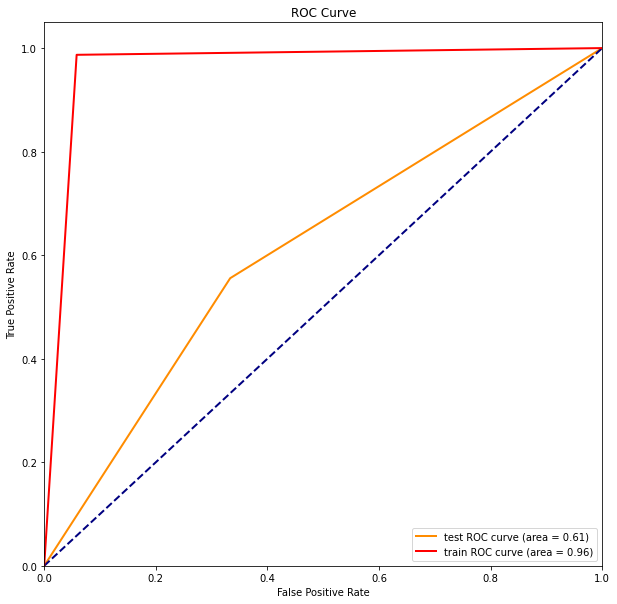


 训练集 0.9631901840490797 测试集 0.6111111111111112
roc: 0.6111111111111112
sensitivity: 0.6666666666666666
specificity: 0.5555555555555556


<Figure size 432x288 with 0 Axes>

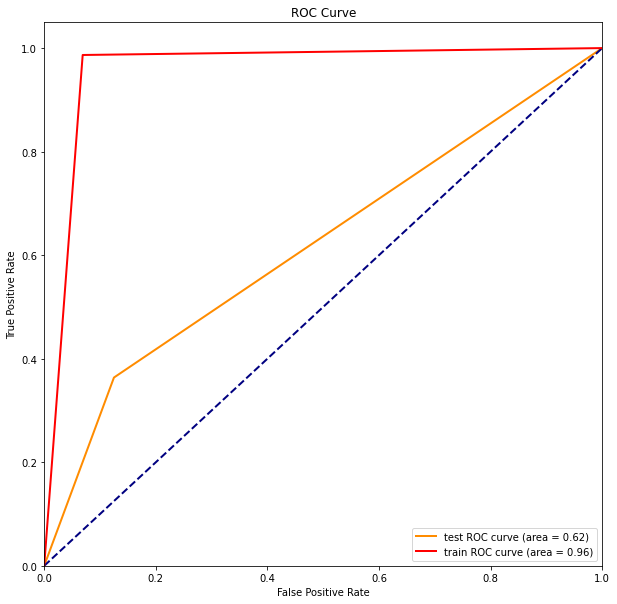


 训练集 0.9567901234567902 测试集 0.5789473684210527
roc: 0.6193181818181819
sensitivity: 0.875
specificity: 0.36363636363636365


<Figure size 432x288 with 0 Axes>

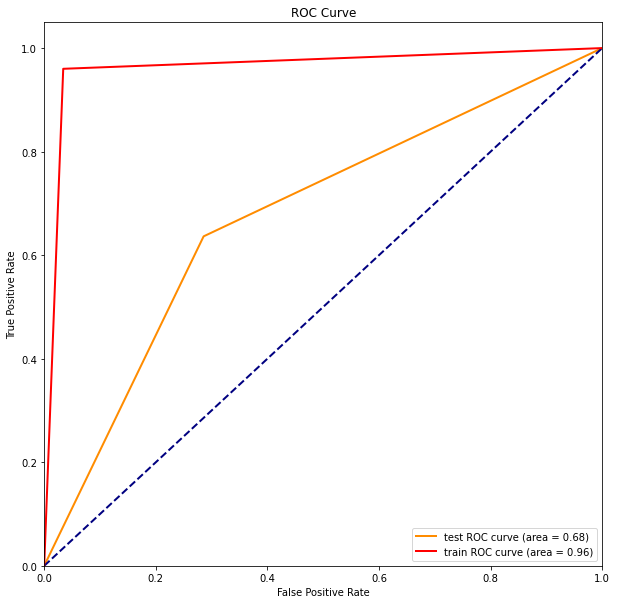


 训练集 0.9631901840490797 测试集 0.6666666666666666
roc: 0.6753246753246753
sensitivity: 0.7142857142857143
specificity: 0.6363636363636364


<Figure size 432x288 with 0 Axes>

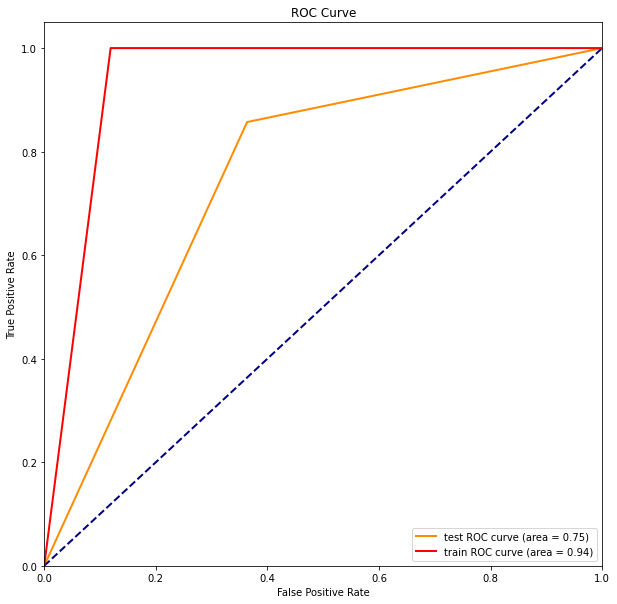


 训练集 0.9386503067484663 测试集 0.7222222222222222
roc: 0.7467532467532467
sensitivity: 0.6363636363636364
specificity: 0.8571428571428571


<Figure size 432x288 with 0 Axes>

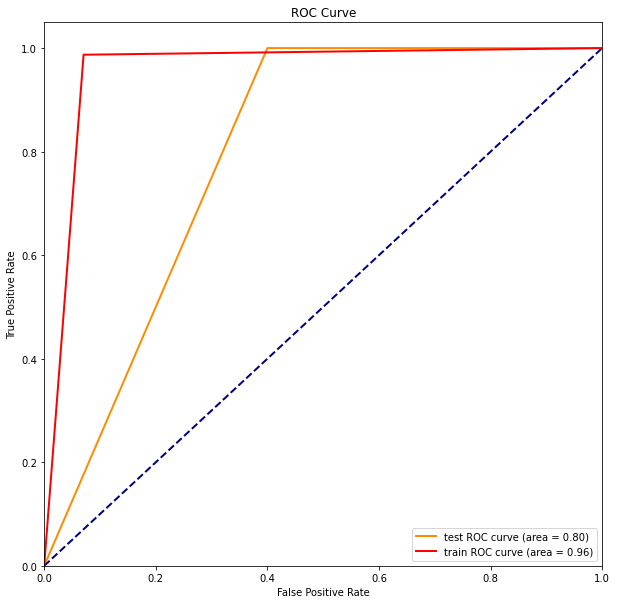


 训练集 0.9570552147239264 测试集 0.7777777777777778
roc: 0.8
sensitivity: 0.6
specificity: 1.0


<Figure size 432x288 with 0 Axes>

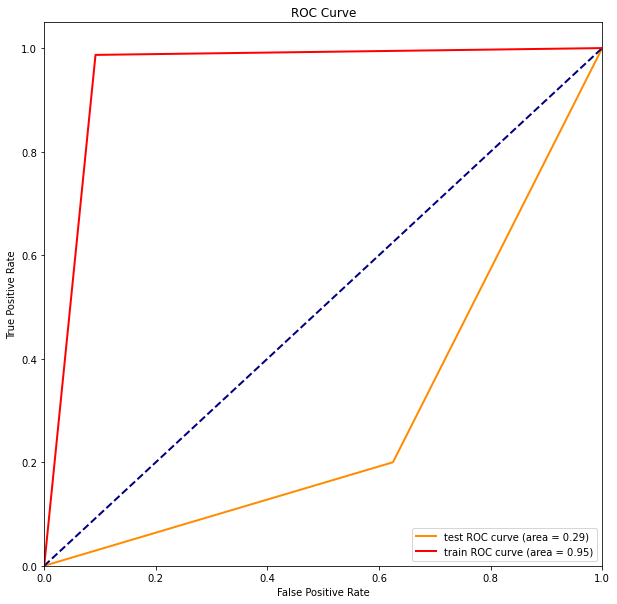


 训练集 0.9447852760736196 测试集 0.2777777777777778
roc: 0.2875
sensitivity: 0.375
specificity: 0.2


<Figure size 432x288 with 0 Axes>

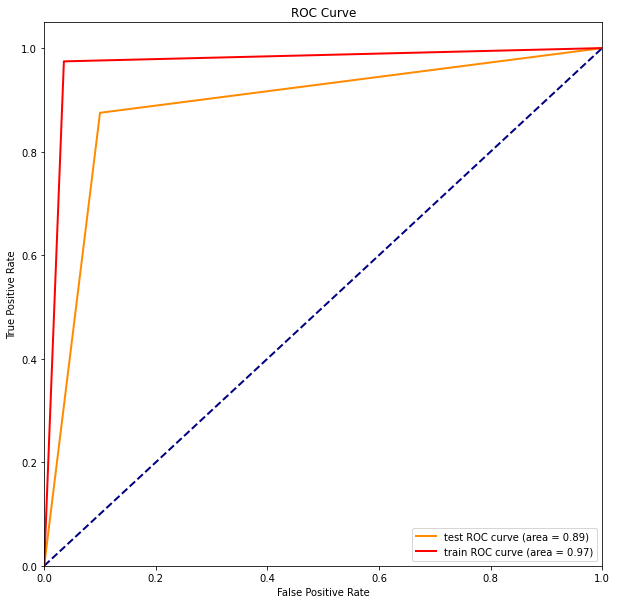


 训练集 0.9693251533742331 测试集 0.8888888888888888
roc: 0.8875
sensitivity: 0.9
specificity: 0.875


<Figure size 432x288 with 0 Axes>

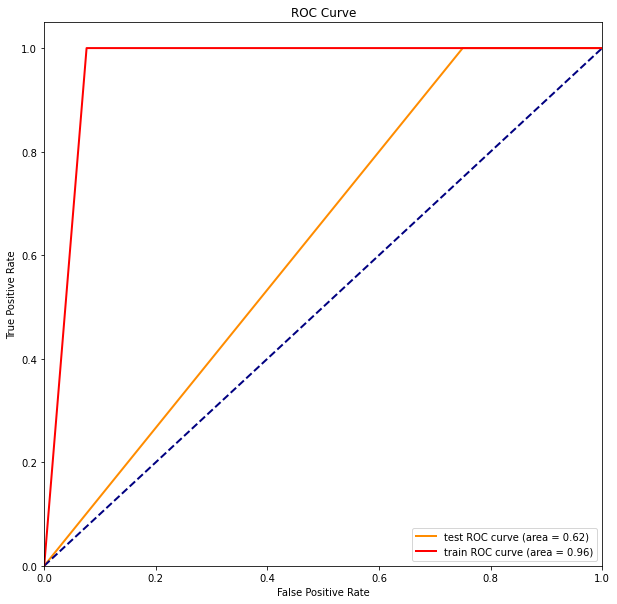


 训练集 0.9631901840490797 测试集 0.3333333333333333
roc: 0.625
sensitivity: 0.25
specificity: 1.0


<Figure size 432x288 with 0 Axes>

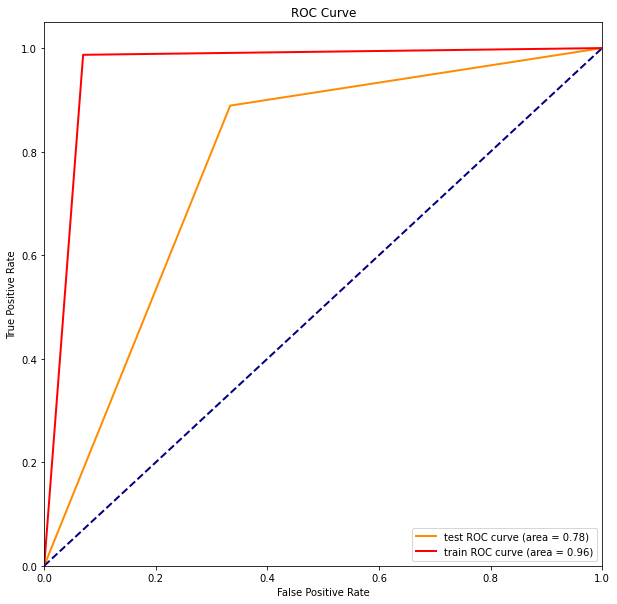


 训练集 0.9570552147239264 测试集 0.7777777777777778
roc: 0.7777777777777778
sensitivity: 0.6666666666666666
specificity: 0.8888888888888888


<Figure size 432x288 with 0 Axes>

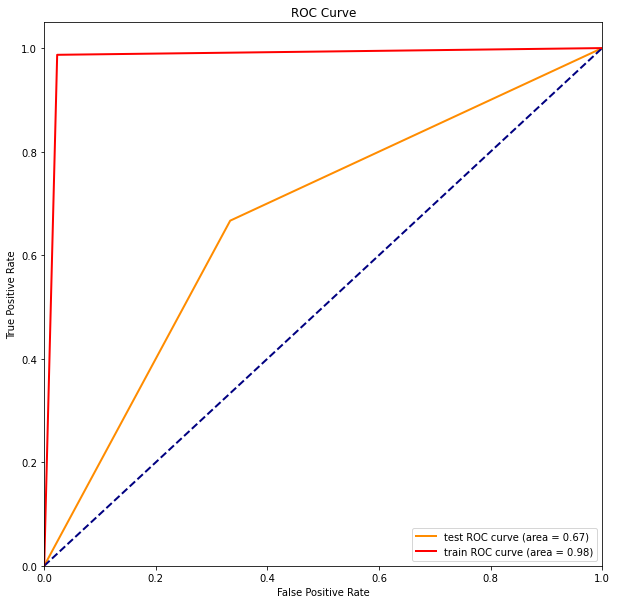


 训练集 0.9815950920245399 测试集 0.6666666666666666
roc: 0.6666666666666667
sensitivity: 0.6666666666666666
specificity: 0.6666666666666666


<Figure size 432x288 with 0 Axes>

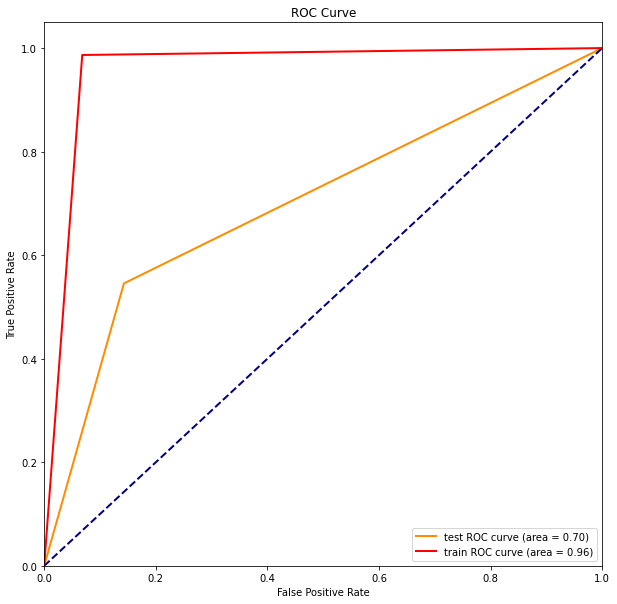


 训练集 0.9570552147239264 测试集 0.6666666666666666
roc: 0.7012987012987013
sensitivity: 0.8571428571428571
specificity: 0.5454545454545454


<Figure size 432x288 with 0 Axes>

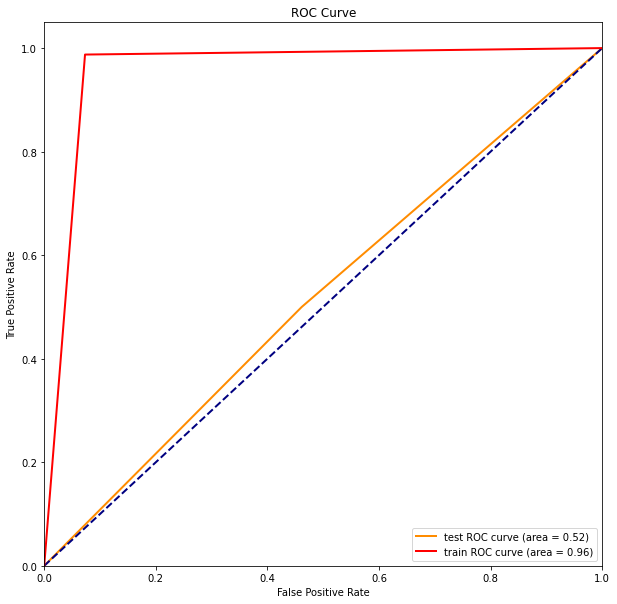


 训练集 0.9567901234567902 测试集 0.5263157894736842
roc: 0.5192307692307693
sensitivity: 0.5384615384615384
specificity: 0.5


<Figure size 432x288 with 0 Axes>

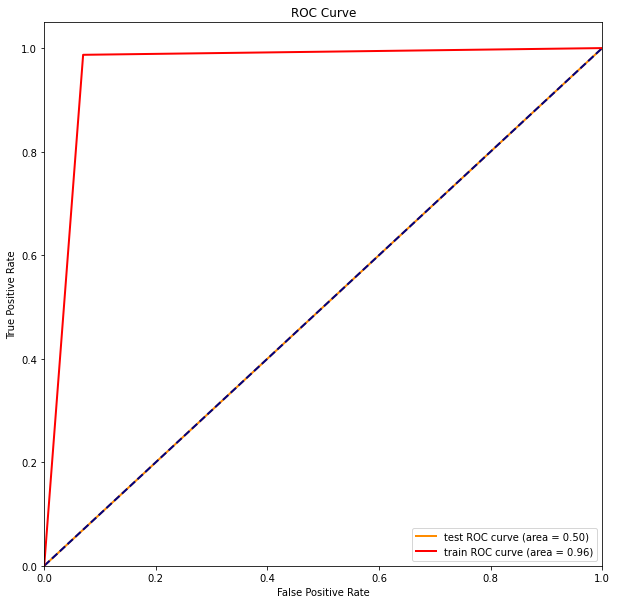


 训练集 0.9570552147239264 测试集 0.5
roc: 0.5
sensitivity: 0.3333333333333333
specificity: 0.6666666666666666


<Figure size 432x288 with 0 Axes>

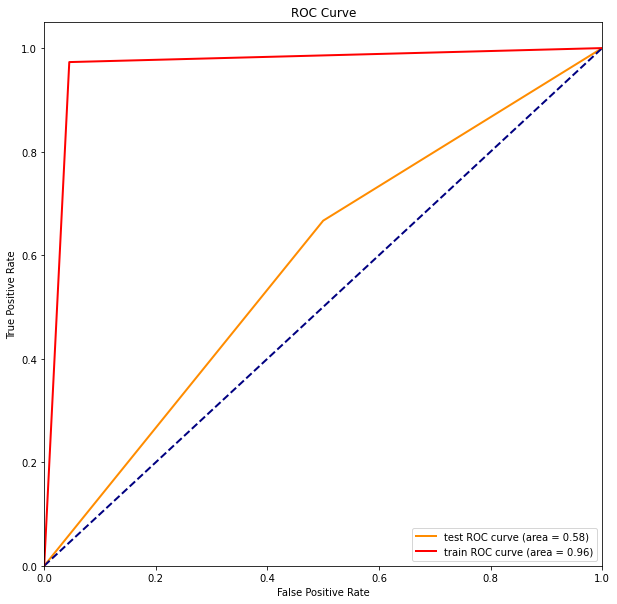


 训练集 0.9631901840490797 测试集 0.6111111111111112
roc: 0.5833333333333333
sensitivity: 0.5
specificity: 0.6666666666666666


<Figure size 432x288 with 0 Axes>

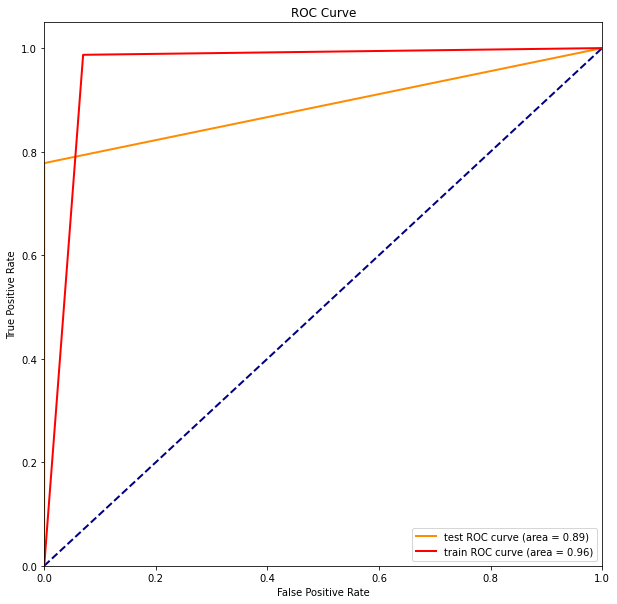


 训练集 0.9570552147239264 测试集 0.8888888888888888
roc: 0.8888888888888888
sensitivity: 1.0
specificity: 0.7777777777777778


<Figure size 432x288 with 0 Axes>

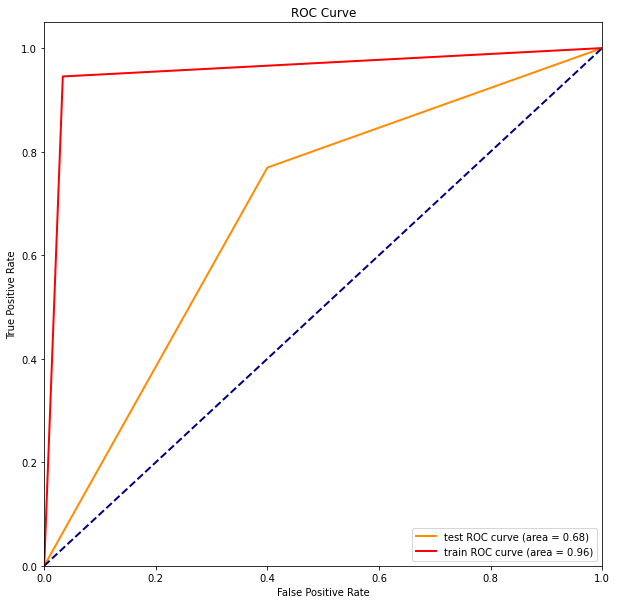


 训练集 0.9570552147239264 测试集 0.7222222222222222
roc: 0.6846153846153846
sensitivity: 0.6
specificity: 0.7692307692307693


<Figure size 432x288 with 0 Axes>

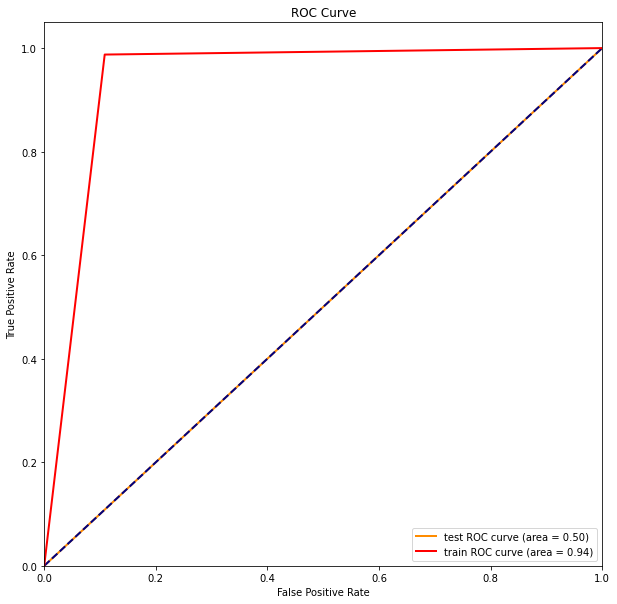


 训练集 0.9386503067484663 测试集 0.4444444444444444
roc: 0.5
sensitivity: 0.3333333333333333
specificity: 0.6666666666666666


<Figure size 432x288 with 0 Axes>

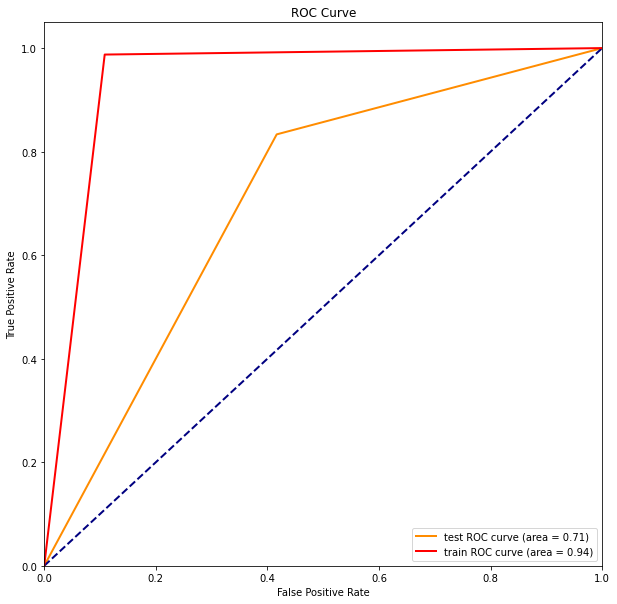


 训练集 0.9386503067484663 测试集 0.6666666666666666
roc: 0.7083333333333334
sensitivity: 0.5833333333333334
specificity: 0.8333333333333334


<Figure size 432x288 with 0 Axes>

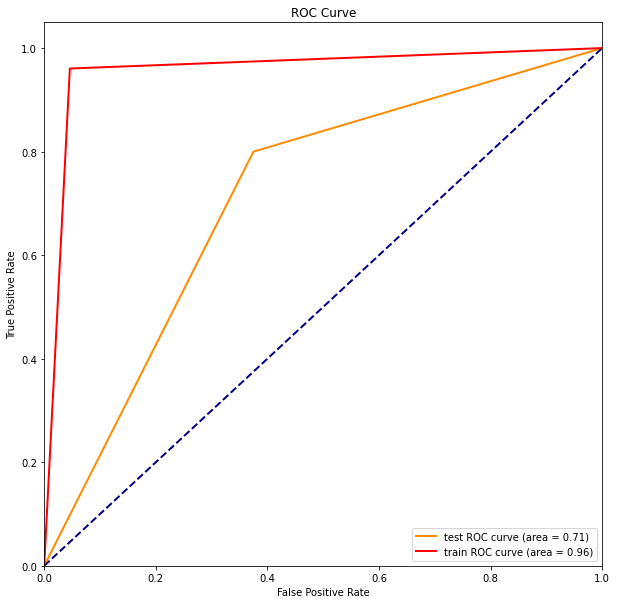


 训练集 0.9570552147239264 测试集 0.7222222222222222
roc: 0.7125
sensitivity: 0.625
specificity: 0.8


<Figure size 432x288 with 0 Axes>

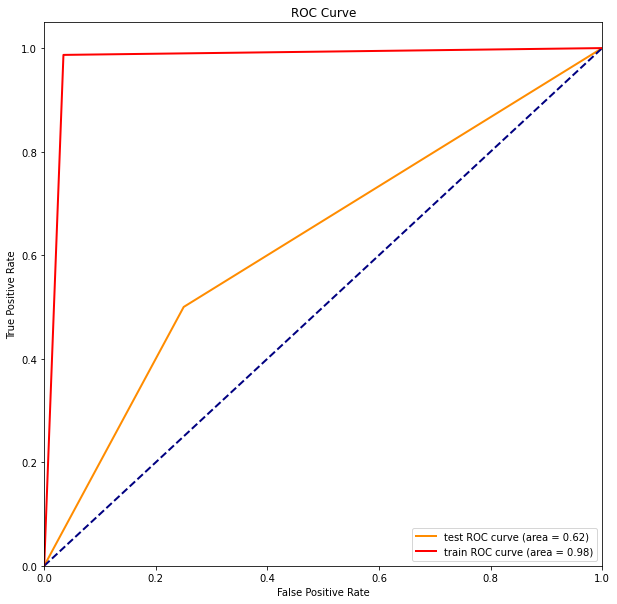


 训练集 0.9754601226993865 测试集 0.6111111111111112
roc: 0.625
sensitivity: 0.75
specificity: 0.5


<Figure size 432x288 with 0 Axes>

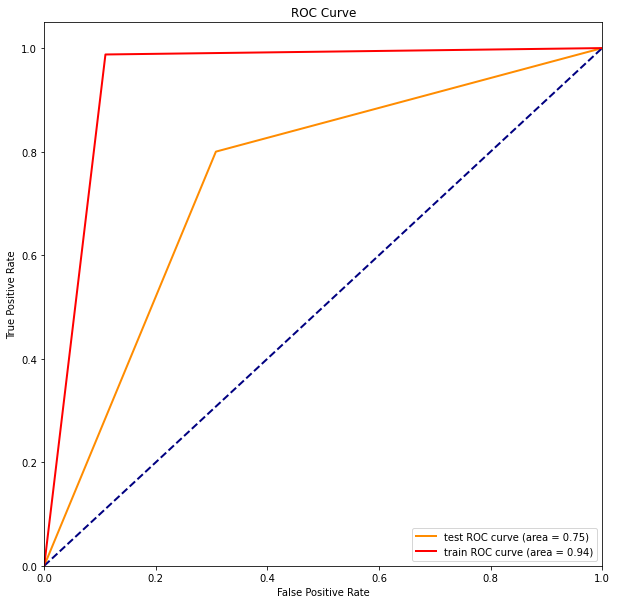


 训练集 0.9386503067484663 测试集 0.7222222222222222
roc: 0.7461538461538462
sensitivity: 0.6923076923076923
specificity: 0.8


<Figure size 432x288 with 0 Axes>

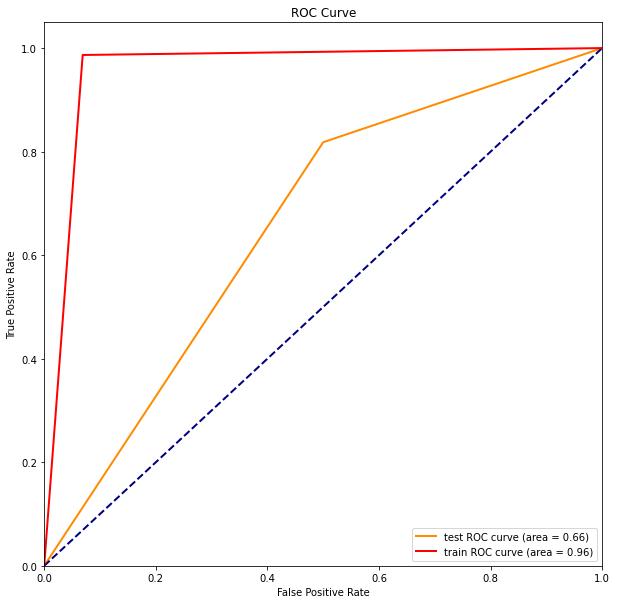


 训练集 0.9567901234567902 测试集 0.6842105263157895
roc: 0.6590909090909092
sensitivity: 0.5
specificity: 0.8181818181818182


<Figure size 432x288 with 0 Axes>

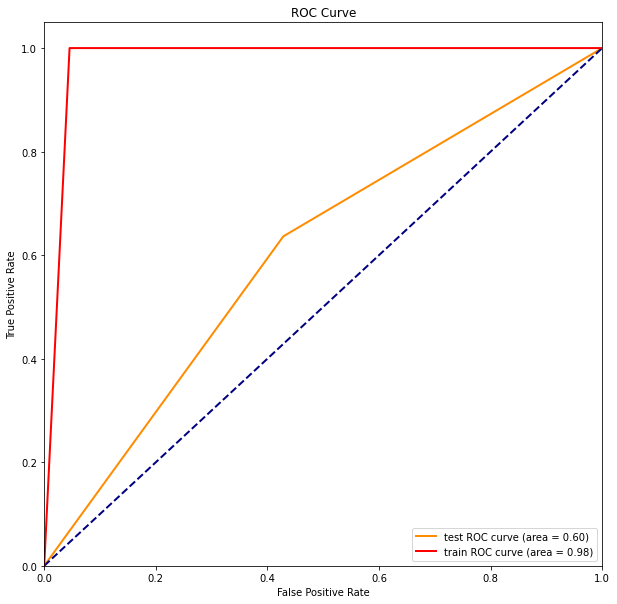


 训练集 0.9754601226993865 测试集 0.6111111111111112
roc: 0.6038961038961038
sensitivity: 0.5714285714285714
specificity: 0.6363636363636364


<Figure size 432x288 with 0 Axes>

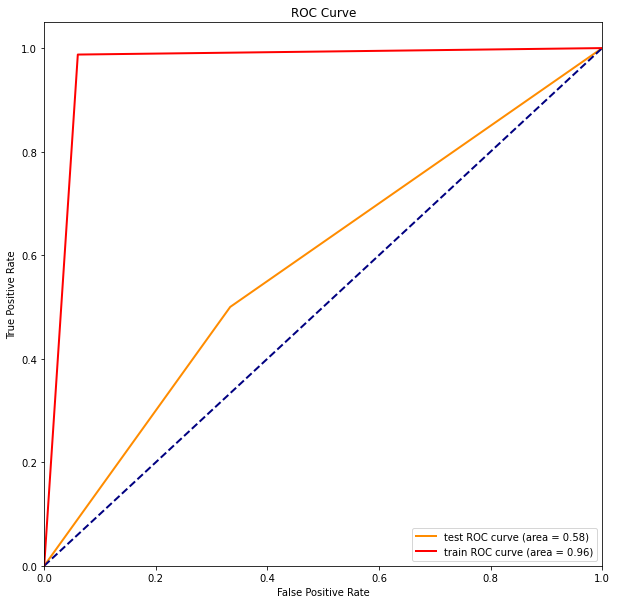


 训练集 0.9631901840490797 测试集 0.6111111111111112
roc: 0.5833333333333334
sensitivity: 0.6666666666666666
specificity: 0.5


<Figure size 432x288 with 0 Axes>

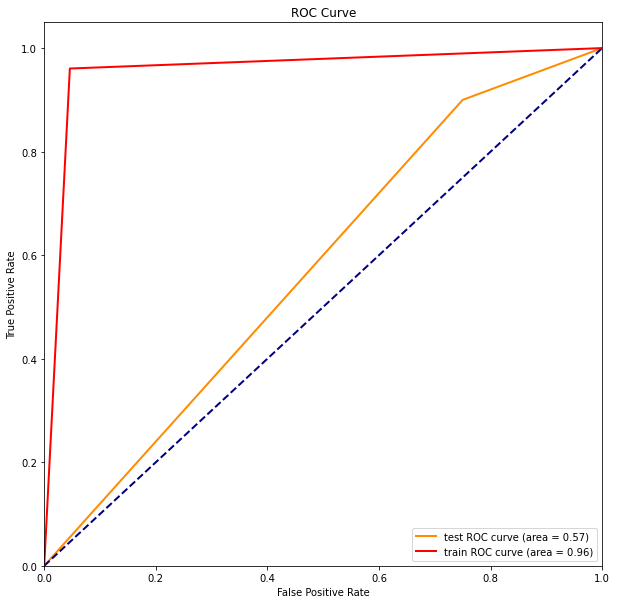


 训练集 0.9570552147239264 测试集 0.6111111111111112
roc: 0.575
sensitivity: 0.25
specificity: 0.9


<Figure size 432x288 with 0 Axes>

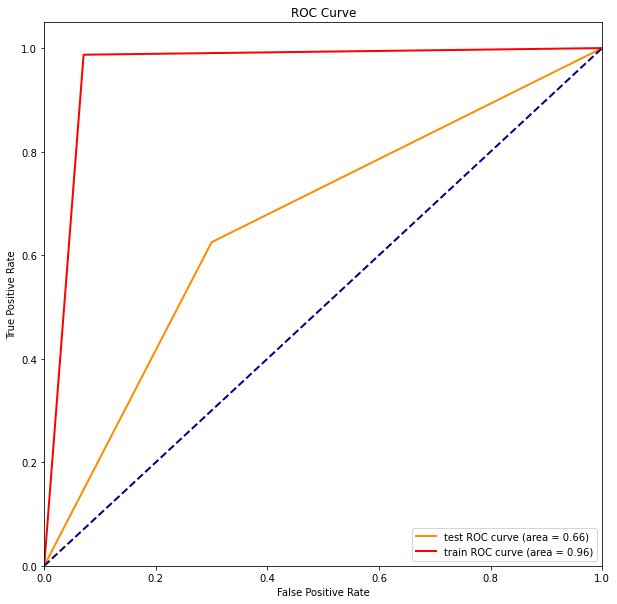


 训练集 0.9570552147239264 测试集 0.6666666666666666
roc: 0.6625
sensitivity: 0.7
specificity: 0.625


<Figure size 432x288 with 0 Axes>

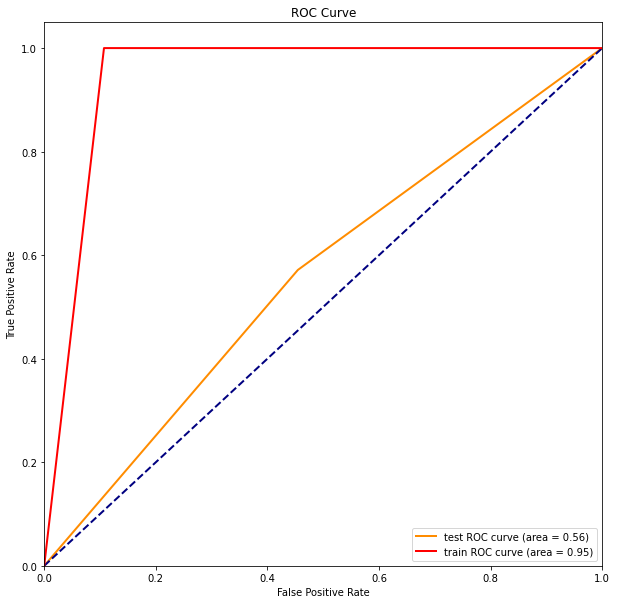


 训练集 0.9447852760736196 测试集 0.5555555555555556
roc: 0.5584415584415584
sensitivity: 0.5454545454545454
specificity: 0.5714285714285714


<Figure size 432x288 with 0 Axes>

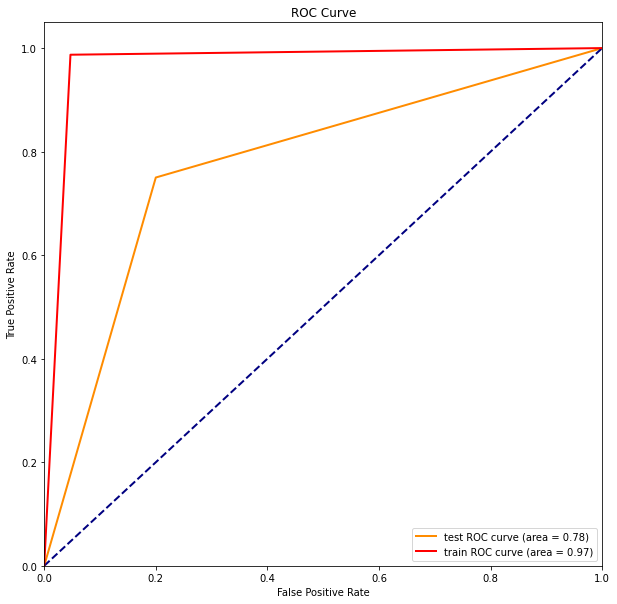


 训练集 0.9693251533742331 测试集 0.7777777777777778
roc: 0.7750000000000001
sensitivity: 0.8
specificity: 0.75


<Figure size 432x288 with 0 Axes>

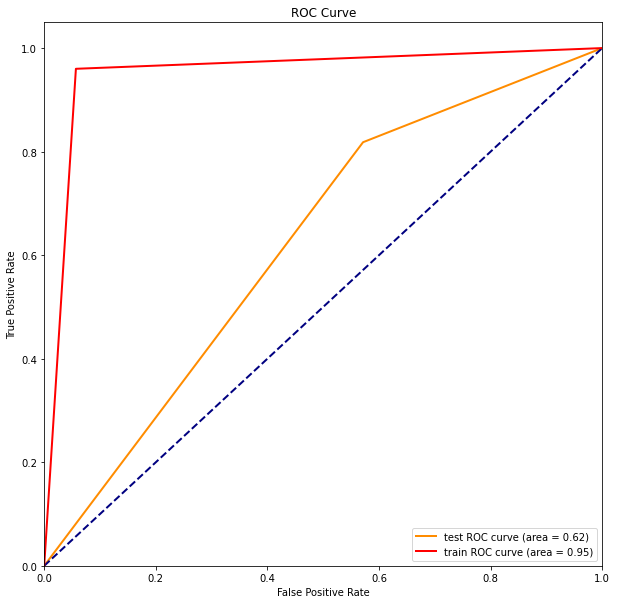


 训练集 0.950920245398773 测试集 0.6666666666666666
roc: 0.6233766233766235
sensitivity: 0.42857142857142855
specificity: 0.8181818181818182


<Figure size 432x288 with 0 Axes>

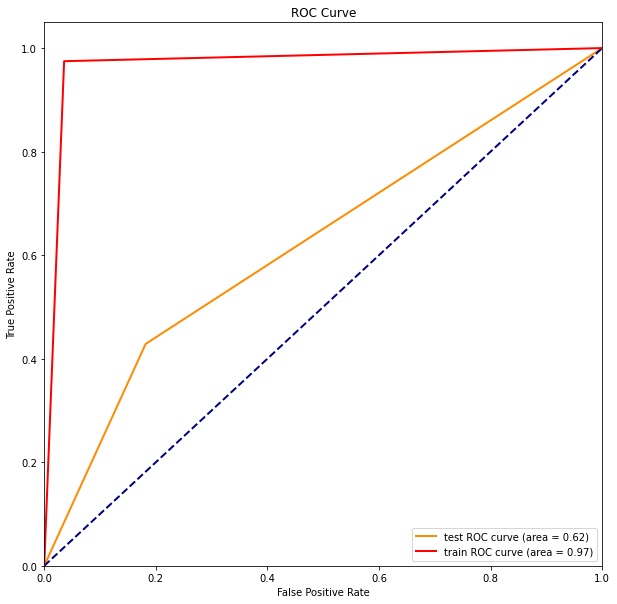


 训练集 0.9693251533742331 测试集 0.6666666666666666
roc: 0.6233766233766234
sensitivity: 0.8181818181818182
specificity: 0.42857142857142855


<Figure size 432x288 with 0 Axes>

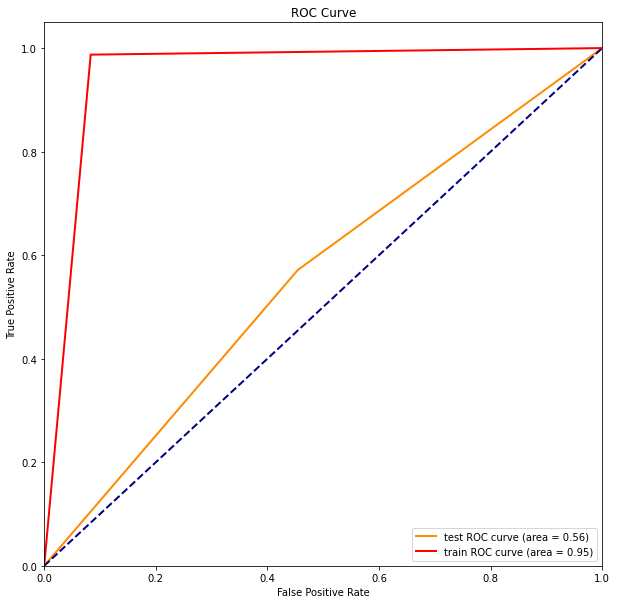


 训练集 0.950920245398773 测试集 0.5555555555555556
roc: 0.5584415584415584
sensitivity: 0.5454545454545454
specificity: 0.5714285714285714


<Figure size 432x288 with 0 Axes>

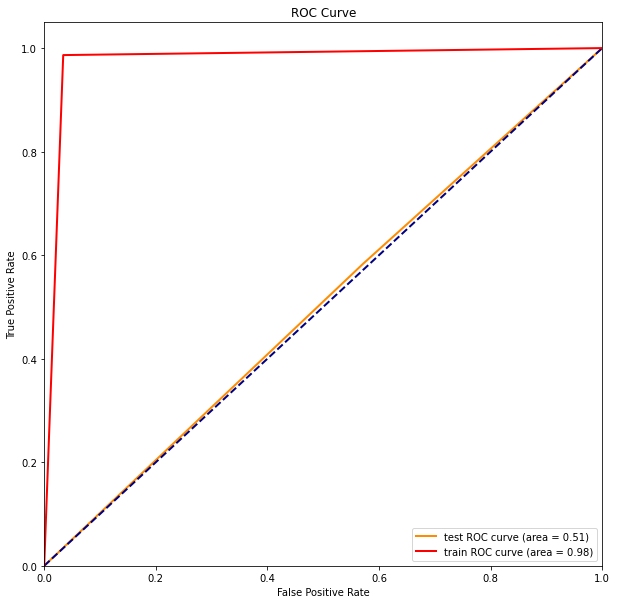


 训练集 0.9753086419753086 测试集 0.5263157894736842
roc: 0.505952380952381
sensitivity: 0.42857142857142855
specificity: 0.5833333333333334


<Figure size 432x288 with 0 Axes>

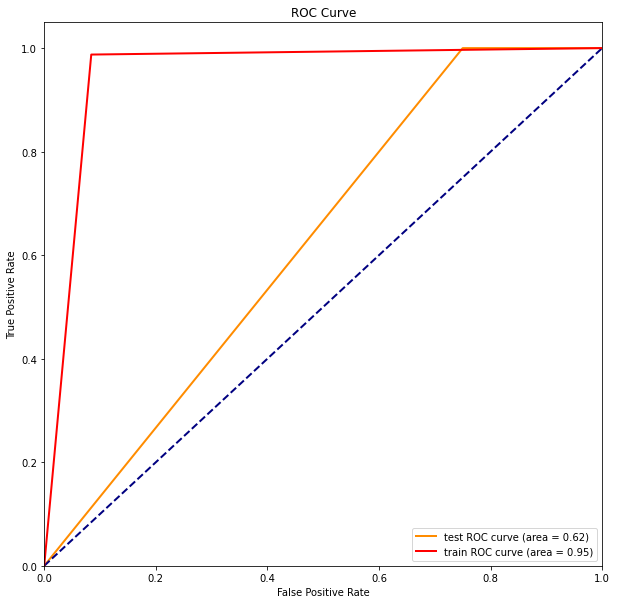


 训练集 0.950920245398773 测试集 0.5
roc: 0.625
sensitivity: 0.25
specificity: 1.0


<Figure size 432x288 with 0 Axes>

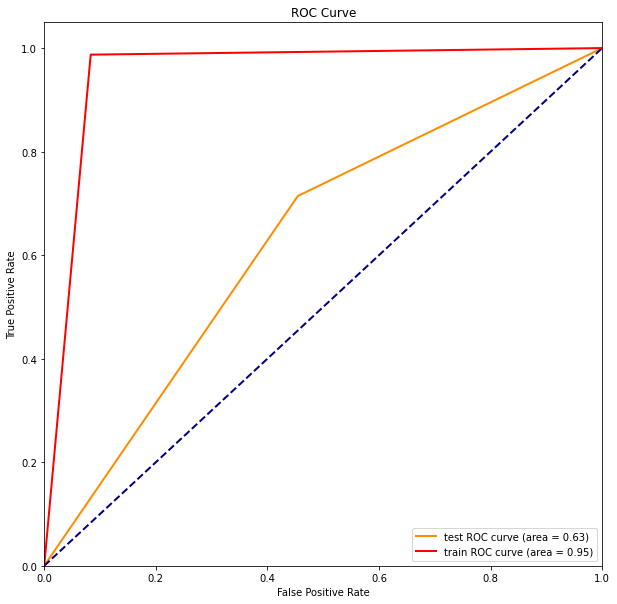


 训练集 0.950920245398773 测试集 0.6111111111111112
roc: 0.6298701298701299
sensitivity: 0.5454545454545454
specificity: 0.7142857142857143


<Figure size 432x288 with 0 Axes>

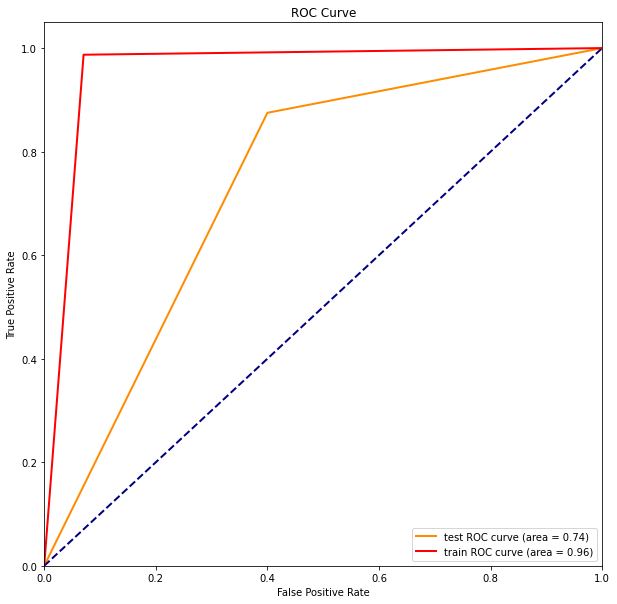


 训练集 0.9570552147239264 测试集 0.7222222222222222
roc: 0.7375
sensitivity: 0.6
specificity: 0.875


<Figure size 432x288 with 0 Axes>

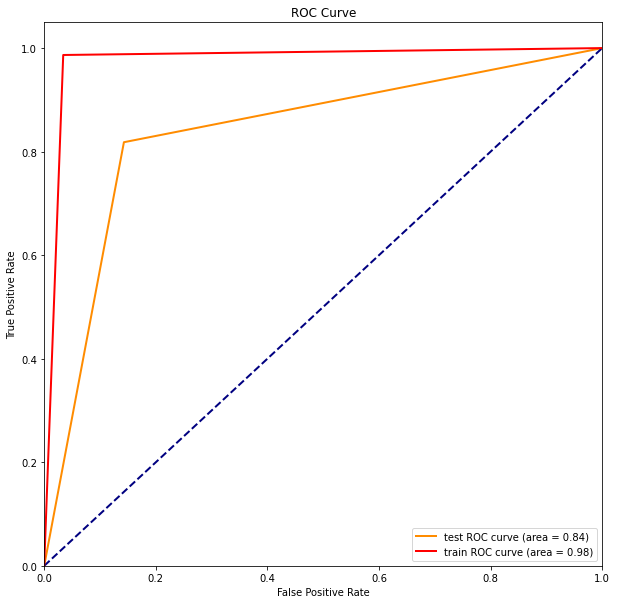


 训练集 0.9754601226993865 测试集 0.8333333333333334
roc: 0.8376623376623378
sensitivity: 0.8571428571428571
specificity: 0.8181818181818182


<Figure size 432x288 with 0 Axes>

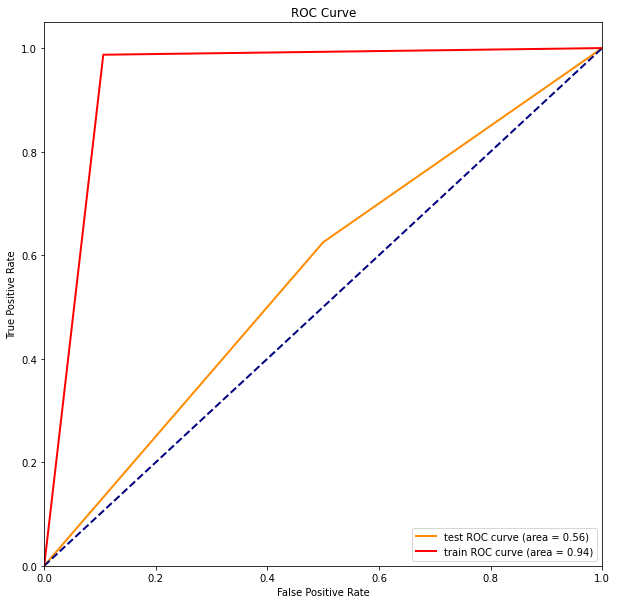


 训练集 0.9386503067484663 测试集 0.5555555555555556
roc: 0.5625
sensitivity: 0.5
specificity: 0.625


<Figure size 432x288 with 0 Axes>

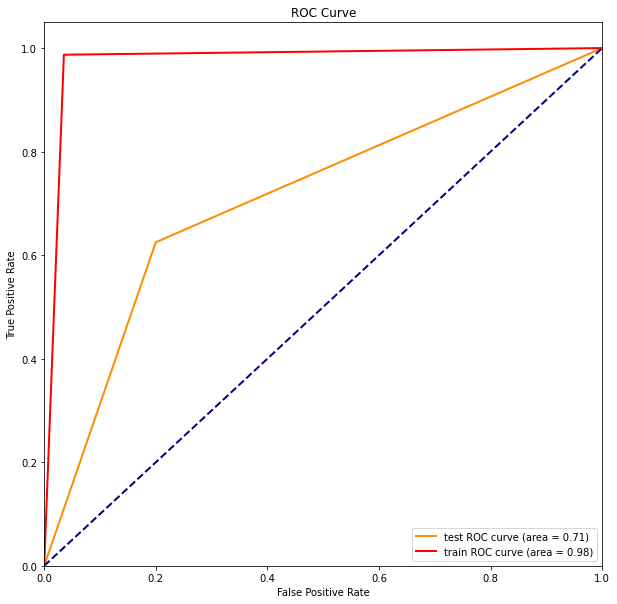


 训练集 0.9754601226993865 测试集 0.7222222222222222
roc: 0.7125
sensitivity: 0.8
specificity: 0.625


<Figure size 432x288 with 0 Axes>

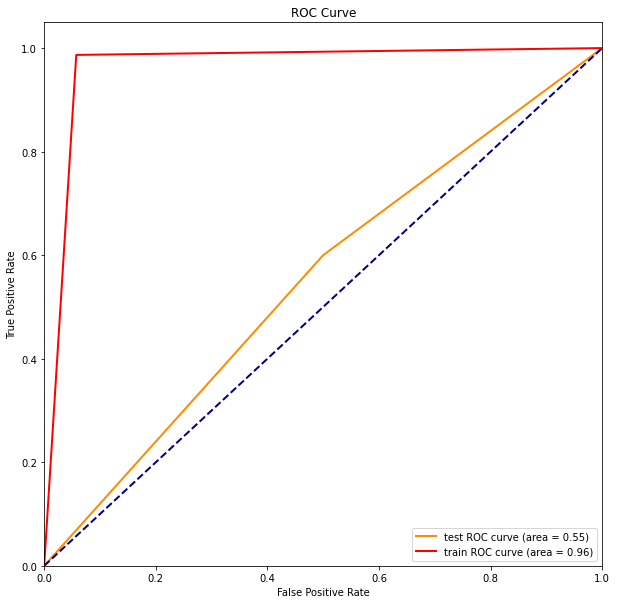


 训练集 0.9631901840490797 测试集 0.5555555555555556
roc: 0.55
sensitivity: 0.5
specificity: 0.6


<Figure size 432x288 with 0 Axes>

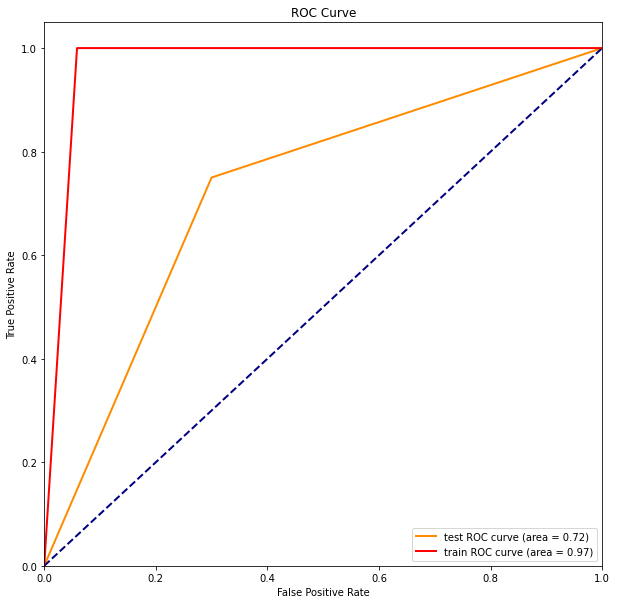


 训练集 0.9693251533742331 测试集 0.7222222222222222
roc: 0.7249999999999999
sensitivity: 0.7
specificity: 0.75


<Figure size 432x288 with 0 Axes>

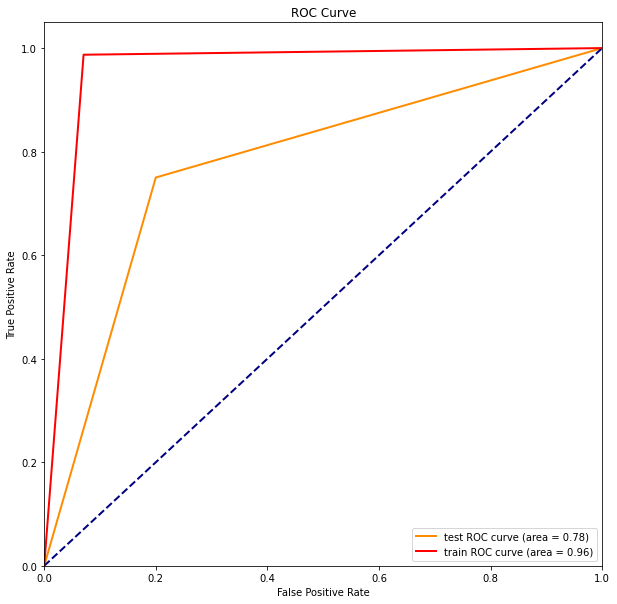


 训练集 0.9570552147239264 测试集 0.7777777777777778
roc: 0.7750000000000001
sensitivity: 0.8
specificity: 0.75


<Figure size 432x288 with 0 Axes>

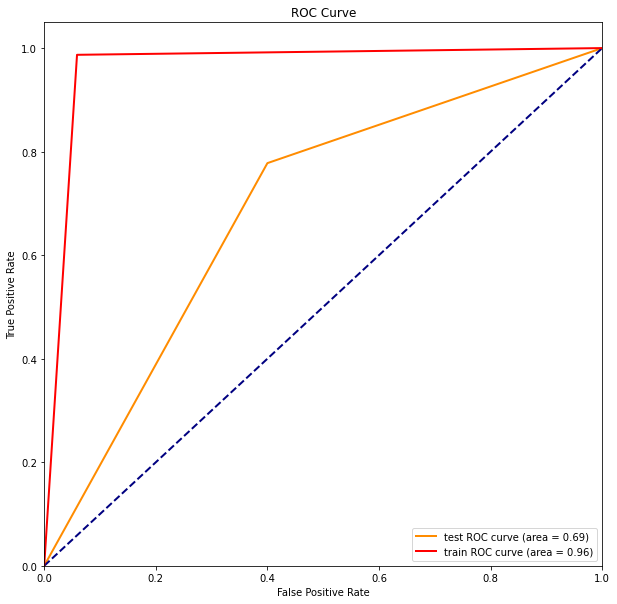


 训练集 0.9629629629629629 测试集 0.6842105263157895
roc: 0.6888888888888889
sensitivity: 0.6
specificity: 0.7777777777777778


<Figure size 432x288 with 0 Axes>

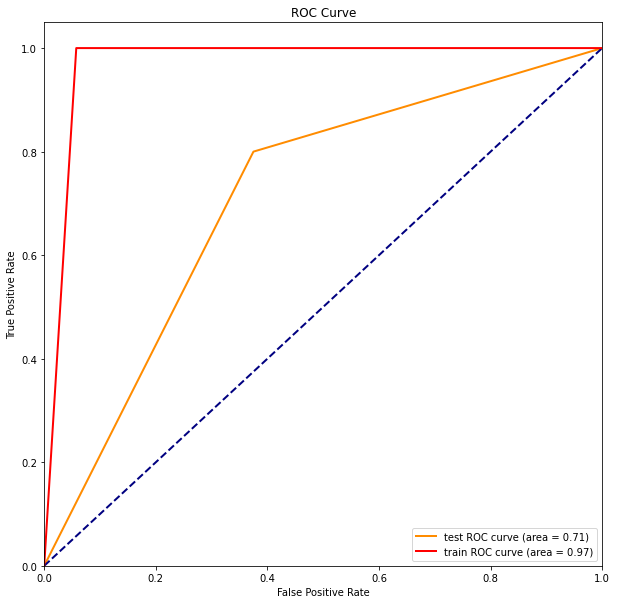


 训练集 0.9693251533742331 测试集 0.7222222222222222
roc: 0.7125
sensitivity: 0.625
specificity: 0.8


<Figure size 432x288 with 0 Axes>

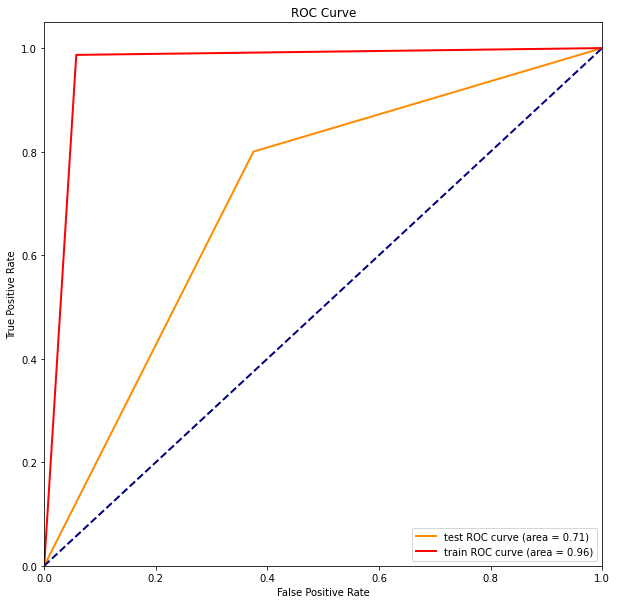


 训练集 0.9631901840490797 测试集 0.7222222222222222
roc: 0.7125
sensitivity: 0.625
specificity: 0.8


<Figure size 432x288 with 0 Axes>

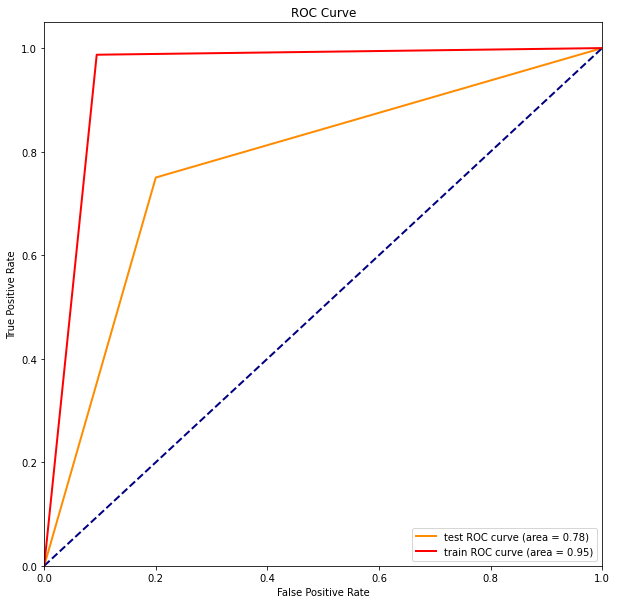


 训练集 0.9447852760736196 测试集 0.7777777777777778
roc: 0.7750000000000001
sensitivity: 0.8
specificity: 0.75


<Figure size 432x288 with 0 Axes>

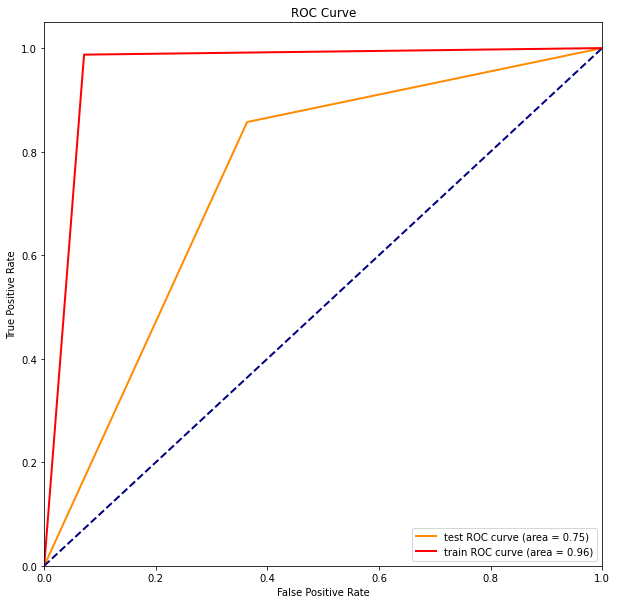


 训练集 0.9570552147239264 测试集 0.7222222222222222
roc: 0.7467532467532467
sensitivity: 0.6363636363636364
specificity: 0.8571428571428571


<Figure size 432x288 with 0 Axes>

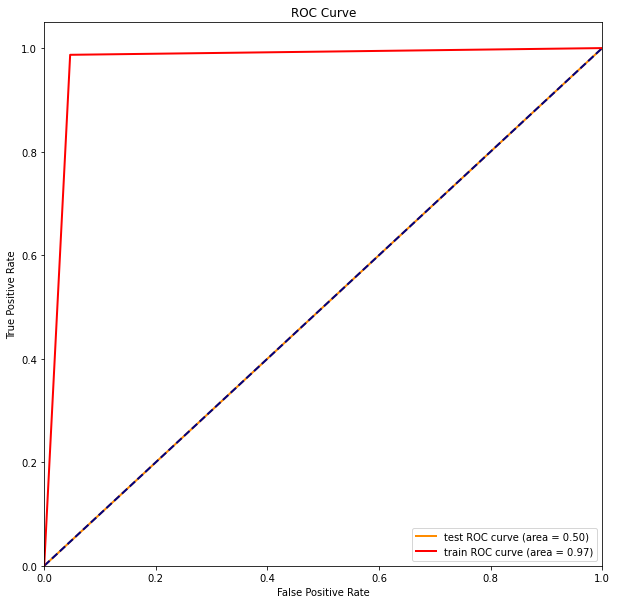


 训练集 0.9693251533742331 测试集 0.5
roc: 0.5
sensitivity: 0.2222222222222222
specificity: 0.7777777777777778


<Figure size 432x288 with 0 Axes>

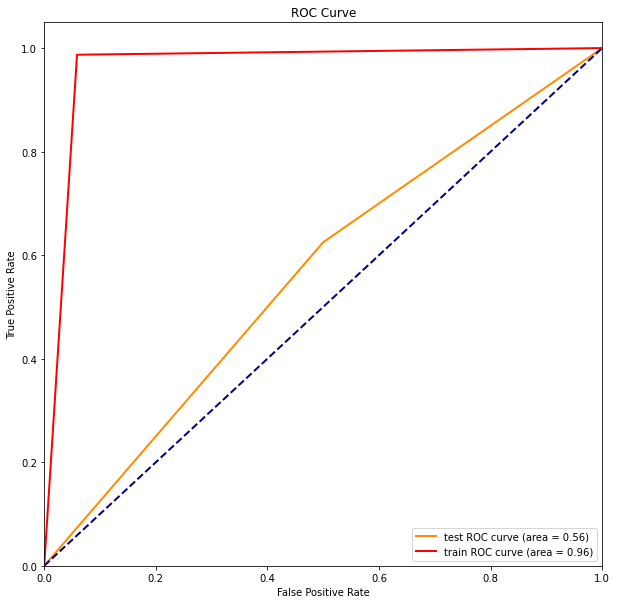


 训练集 0.9631901840490797 测试集 0.5555555555555556
roc: 0.5625
sensitivity: 0.5
specificity: 0.625


<Figure size 432x288 with 0 Axes>

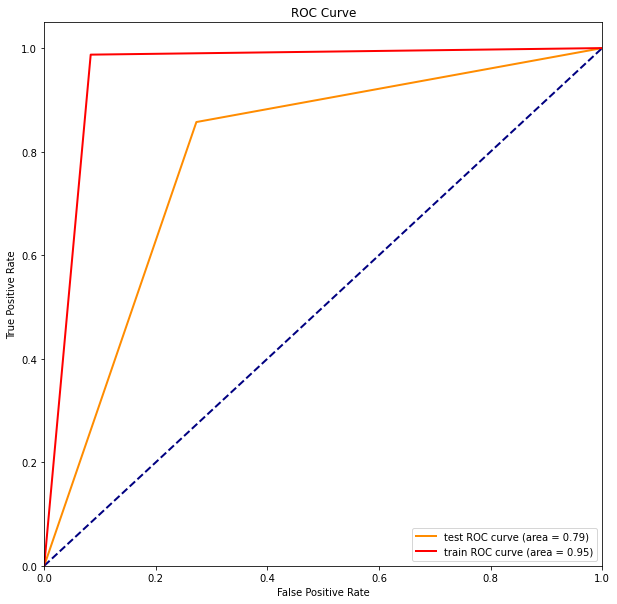


 训练集 0.950920245398773 测试集 0.7777777777777778
roc: 0.7922077922077921
sensitivity: 0.7272727272727273
specificity: 0.8571428571428571


<Figure size 432x288 with 0 Axes>

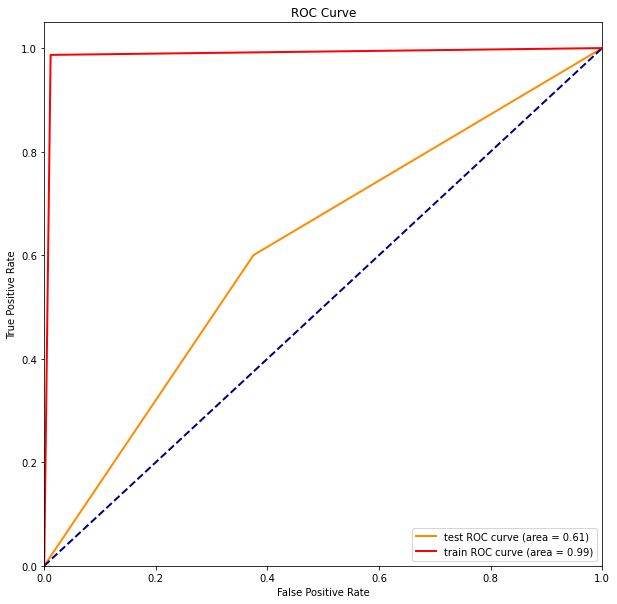


 训练集 0.9877300613496932 测试集 0.6111111111111112
roc: 0.6125
sensitivity: 0.625
specificity: 0.6


<Figure size 432x288 with 0 Axes>

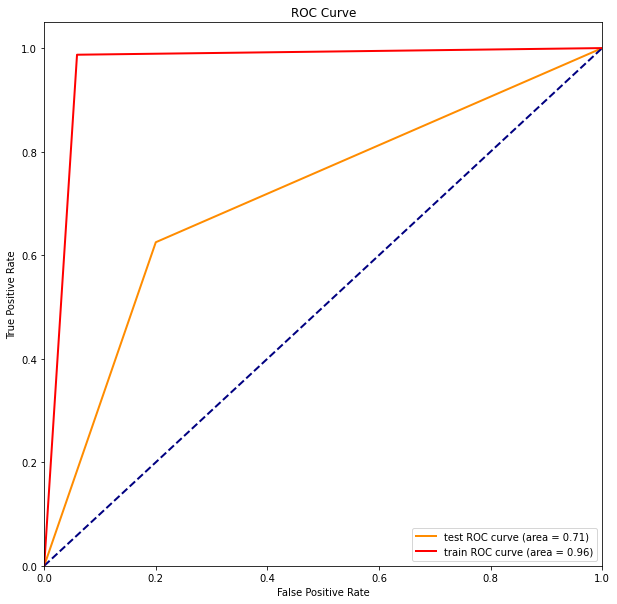


 训练集 0.9631901840490797 测试集 0.7222222222222222
roc: 0.7125
sensitivity: 0.8
specificity: 0.625


<Figure size 432x288 with 0 Axes>

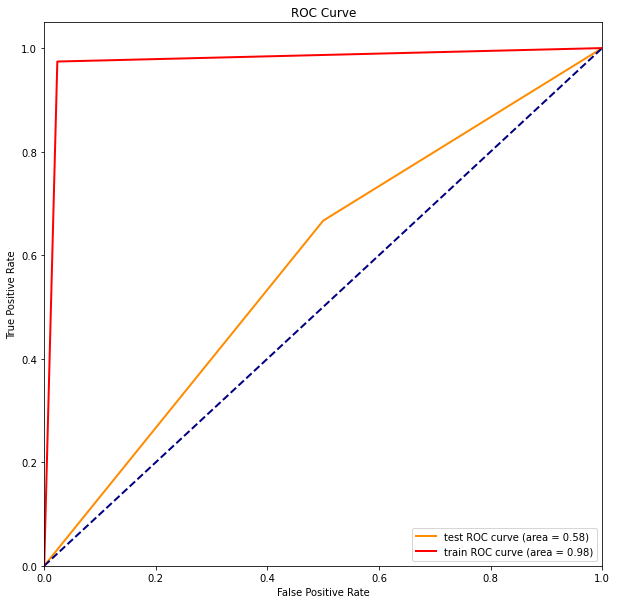


 训练集 0.9753086419753086 测试集 0.5789473684210527
roc: 0.5833333333333333
sensitivity: 0.5
specificity: 0.6666666666666666


<Figure size 432x288 with 0 Axes>

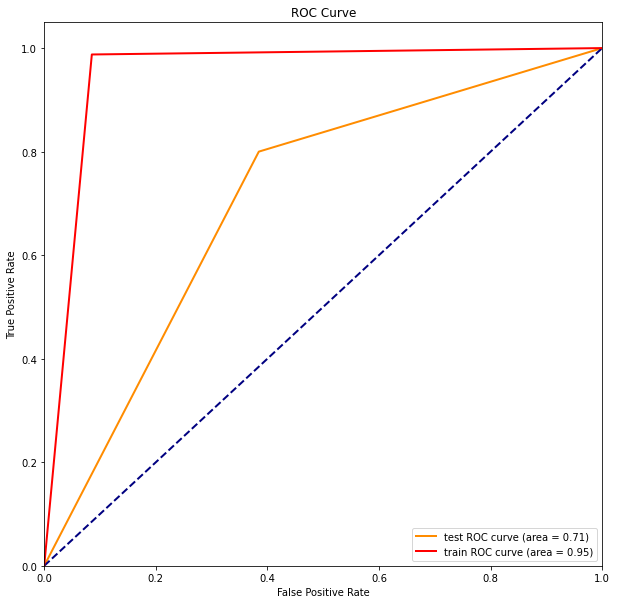


 训练集 0.950920245398773 测试集 0.6666666666666666
roc: 0.7076923076923077
sensitivity: 0.6153846153846154
specificity: 0.8


<Figure size 432x288 with 0 Axes>

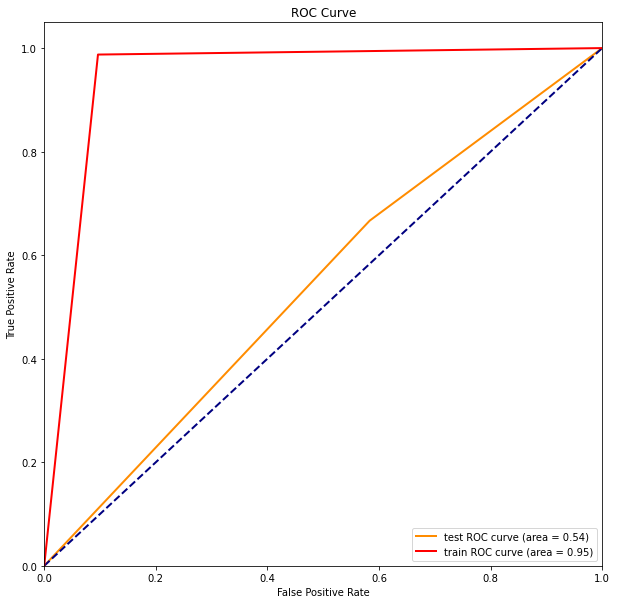


 训练集 0.9447852760736196 测试集 0.5
roc: 0.5416666666666666
sensitivity: 0.4166666666666667
specificity: 0.6666666666666666


<Figure size 432x288 with 0 Axes>

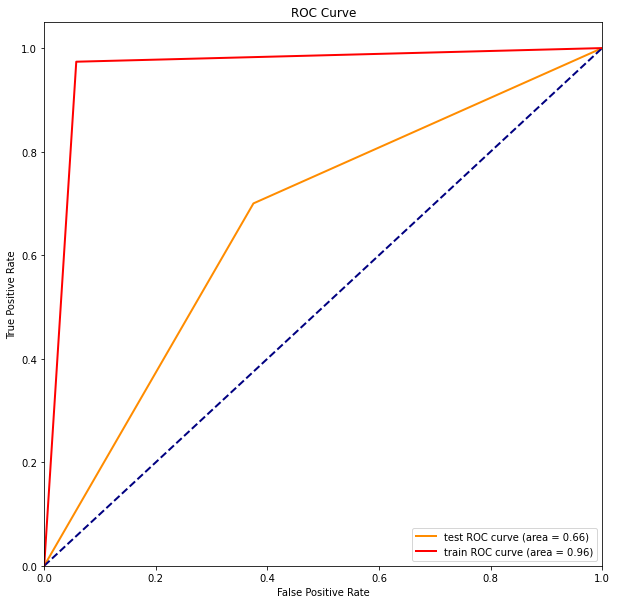


 训练集 0.9570552147239264 测试集 0.6666666666666666
roc: 0.6625
sensitivity: 0.625
specificity: 0.7


<Figure size 432x288 with 0 Axes>

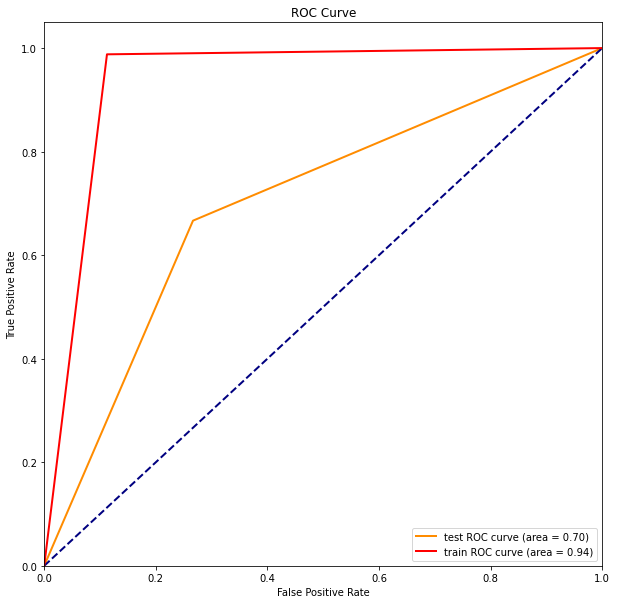


 训练集 0.9386503067484663 测试集 0.7222222222222222
roc: 0.7000000000000001
sensitivity: 0.7333333333333333
specificity: 0.6666666666666666


<Figure size 432x288 with 0 Axes>

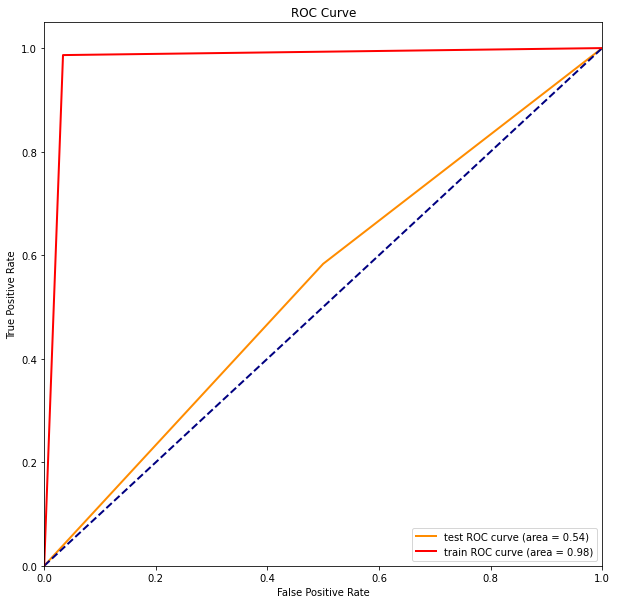


 训练集 0.9754601226993865 测试集 0.5555555555555556
roc: 0.5416666666666667
sensitivity: 0.5
specificity: 0.5833333333333334


<Figure size 432x288 with 0 Axes>

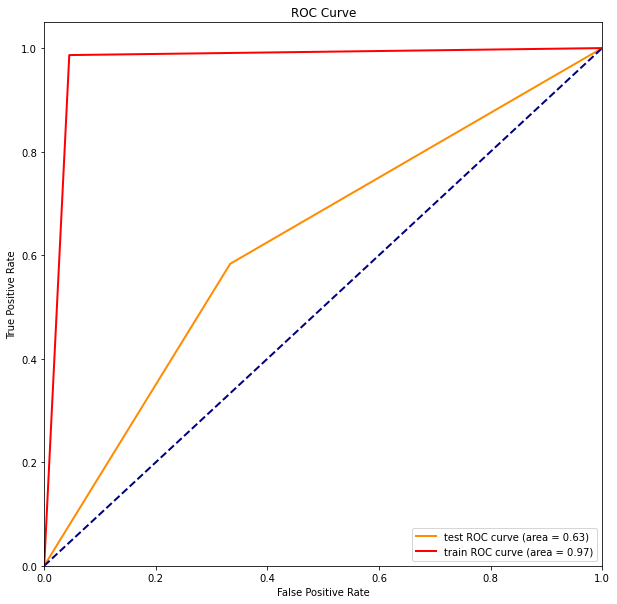


 训练集 0.9693251533742331 测试集 0.6111111111111112
roc: 0.6250000000000001
sensitivity: 0.6666666666666666
specificity: 0.5833333333333334


<Figure size 432x288 with 0 Axes>

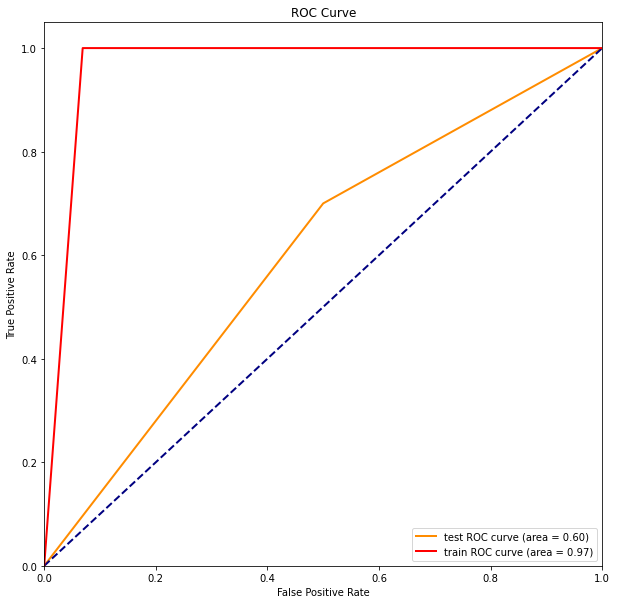


 训练集 0.9631901840490797 测试集 0.6111111111111112
roc: 0.6
sensitivity: 0.5
specificity: 0.7


<Figure size 432x288 with 0 Axes>

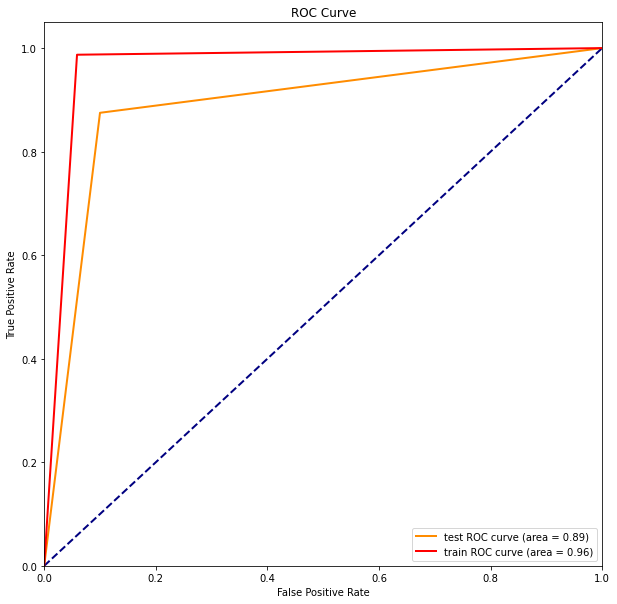


 训练集 0.9631901840490797 测试集 0.8888888888888888
roc: 0.8875
sensitivity: 0.9
specificity: 0.875


<Figure size 432x288 with 0 Axes>

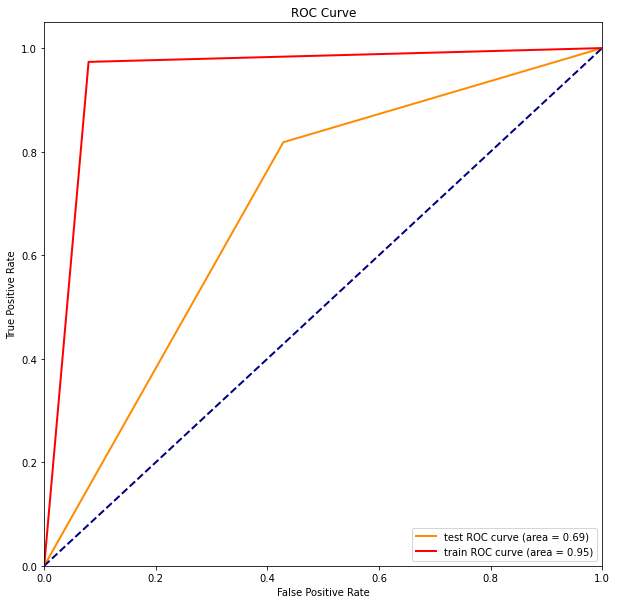


 训练集 0.9447852760736196 测试集 0.7222222222222222
roc: 0.6948051948051949
sensitivity: 0.5714285714285714
specificity: 0.8181818181818182


<Figure size 432x288 with 0 Axes>

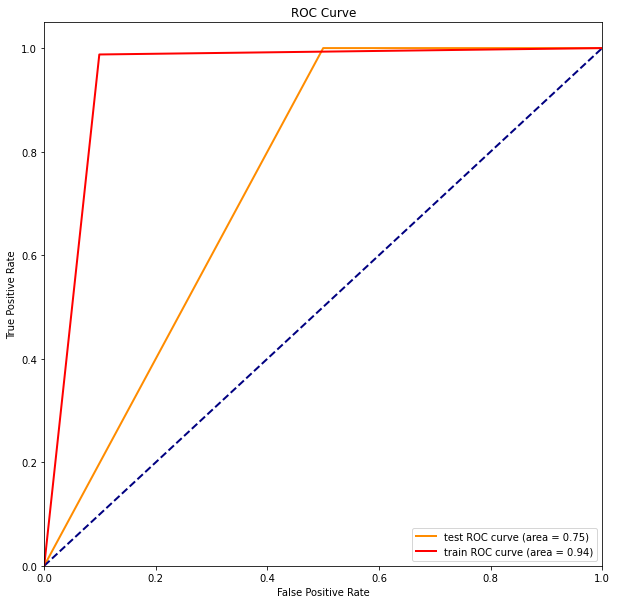


 训练集 0.9444444444444444 测试集 0.631578947368421
roc: 0.75
sensitivity: 0.5
specificity: 1.0


<Figure size 432x288 with 0 Axes>

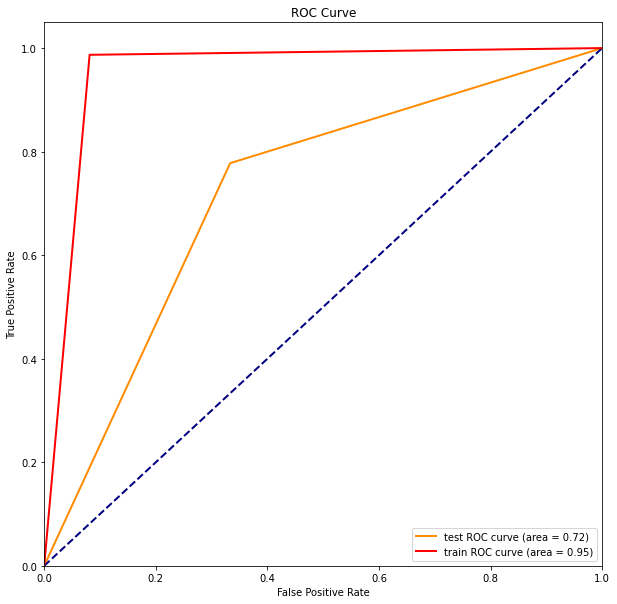


 训练集 0.950920245398773 测试集 0.7222222222222222
roc: 0.7222222222222223
sensitivity: 0.6666666666666666
specificity: 0.7777777777777778


<Figure size 432x288 with 0 Axes>

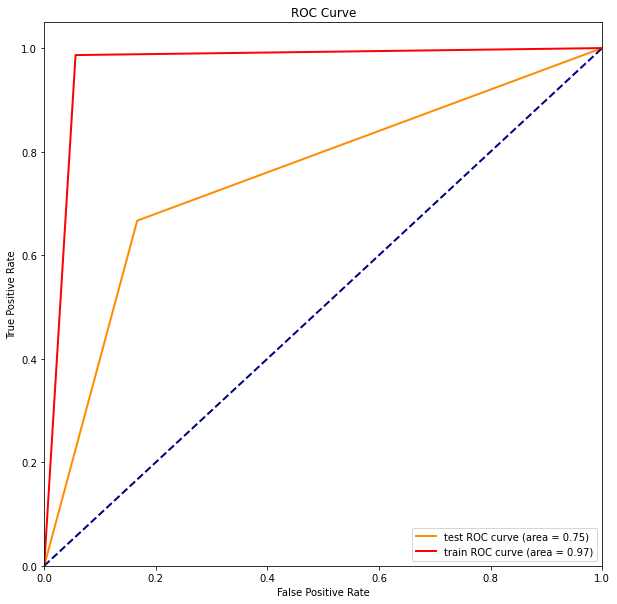


 训练集 0.9631901840490797 测试集 0.7222222222222222
roc: 0.75
sensitivity: 0.8333333333333334
specificity: 0.6666666666666666


<Figure size 432x288 with 0 Axes>

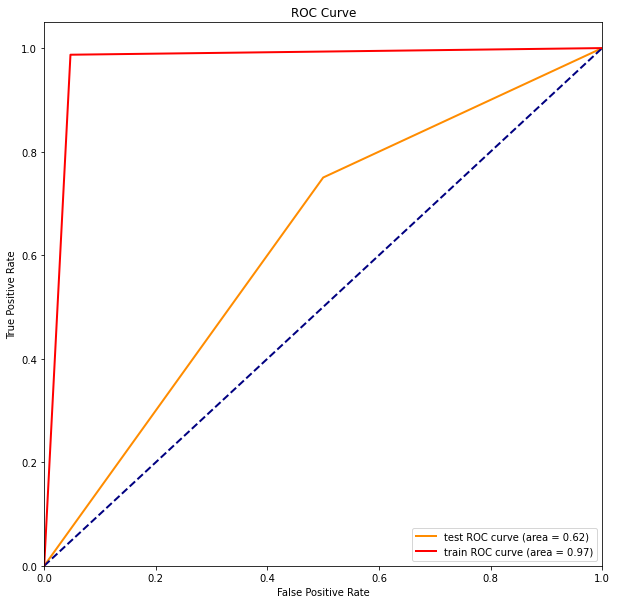


 训练集 0.9693251533742331 测试集 0.6111111111111112
roc: 0.625
sensitivity: 0.5
specificity: 0.75


<Figure size 432x288 with 0 Axes>

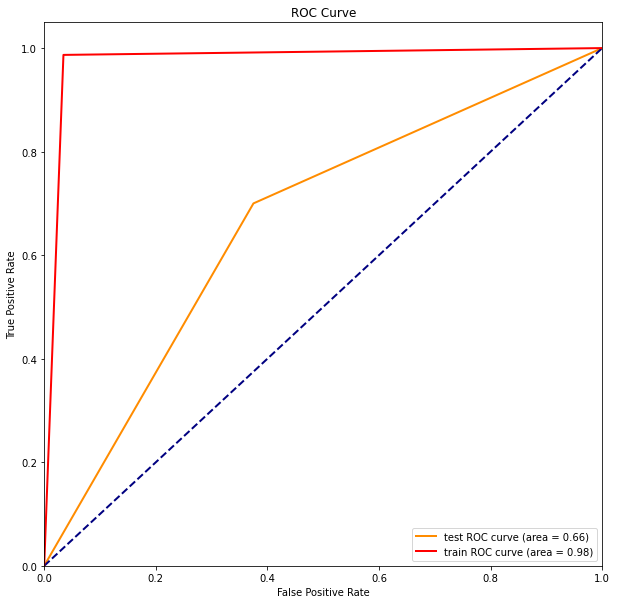


 训练集 0.9754601226993865 测试集 0.6666666666666666
roc: 0.6625
sensitivity: 0.625
specificity: 0.7


<Figure size 432x288 with 0 Axes>

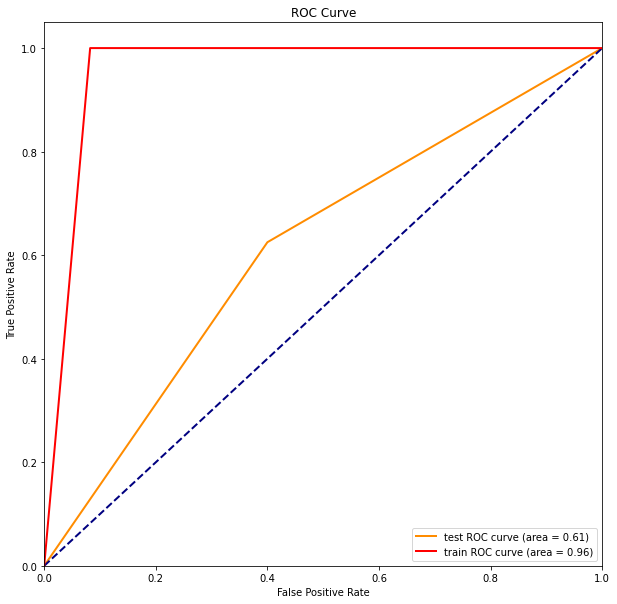


 训练集 0.9570552147239264 测试集 0.6111111111111112
roc: 0.6125
sensitivity: 0.6
specificity: 0.625


<Figure size 432x288 with 0 Axes>

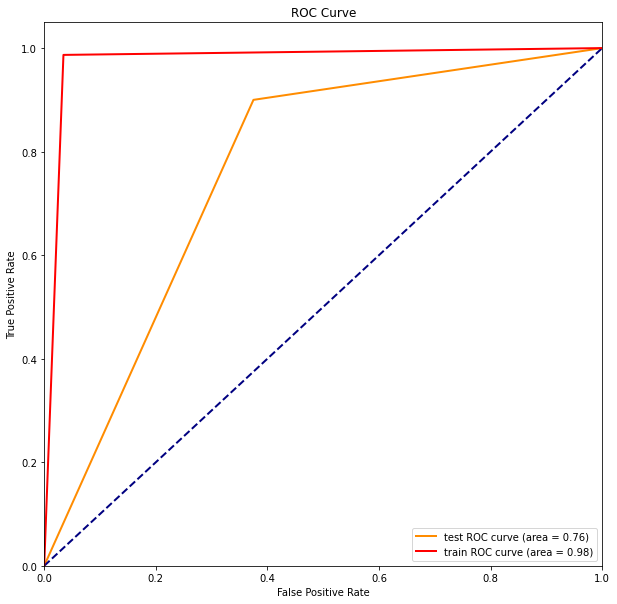


 训练集 0.9754601226993865 测试集 0.7777777777777778
roc: 0.7625
sensitivity: 0.625
specificity: 0.9


<Figure size 432x288 with 0 Axes>

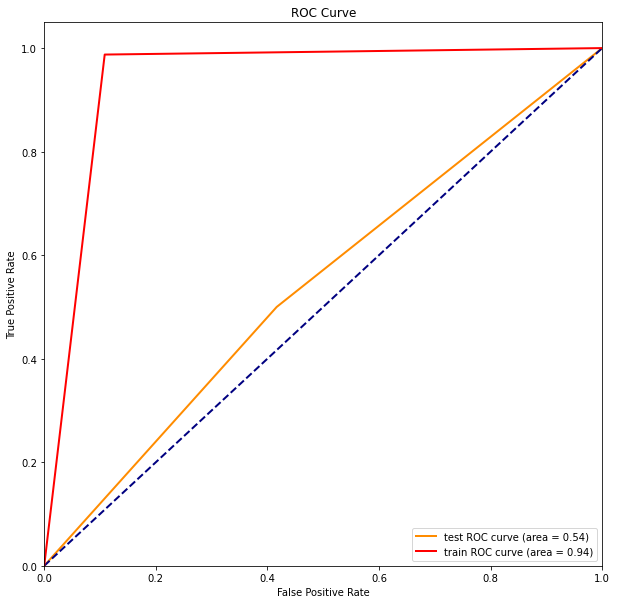


 训练集 0.9386503067484663 测试集 0.5555555555555556
roc: 0.5416666666666666
sensitivity: 0.5833333333333334
specificity: 0.5


<Figure size 432x288 with 0 Axes>

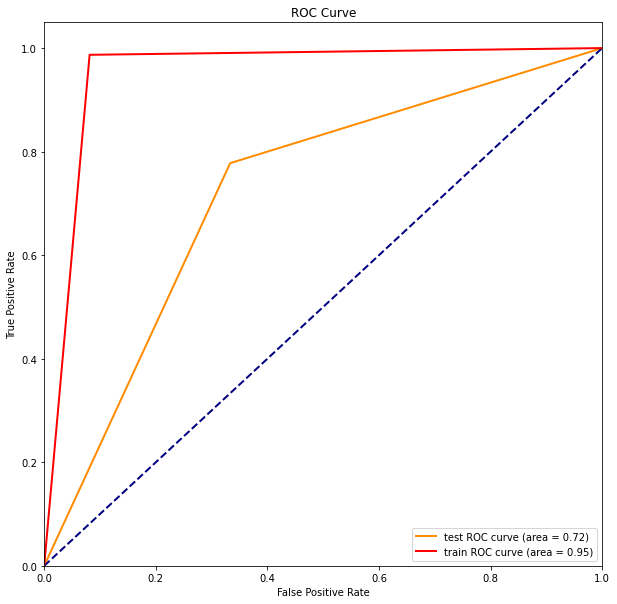


 训练集 0.950920245398773 测试集 0.7222222222222222
roc: 0.7222222222222223
sensitivity: 0.6666666666666666
specificity: 0.7777777777777778


<Figure size 432x288 with 0 Axes>

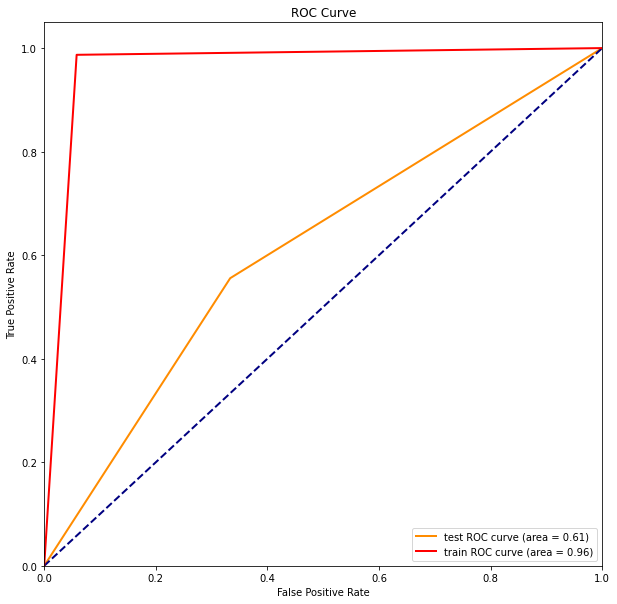


 训练集 0.9631901840490797 测试集 0.6111111111111112
roc: 0.6111111111111112
sensitivity: 0.6666666666666666
specificity: 0.5555555555555556


<Figure size 432x288 with 0 Axes>

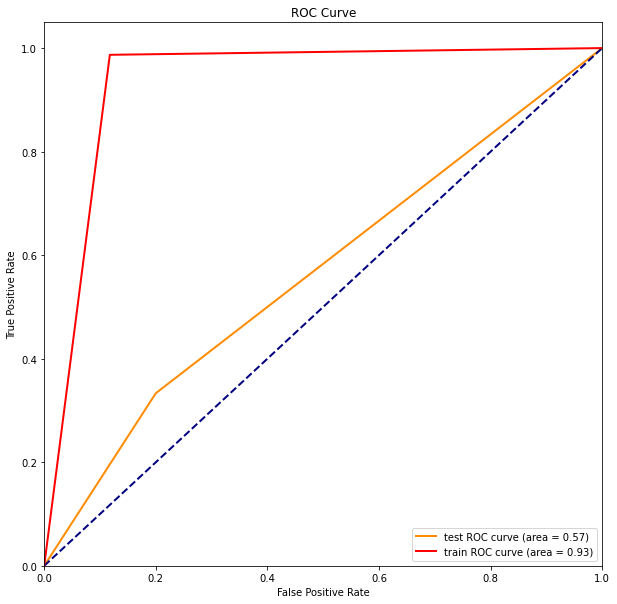


 训练集 0.9320987654320988 测试集 0.5789473684210527
roc: 0.5666666666666667
sensitivity: 0.8
specificity: 0.3333333333333333


<Figure size 432x288 with 0 Axes>

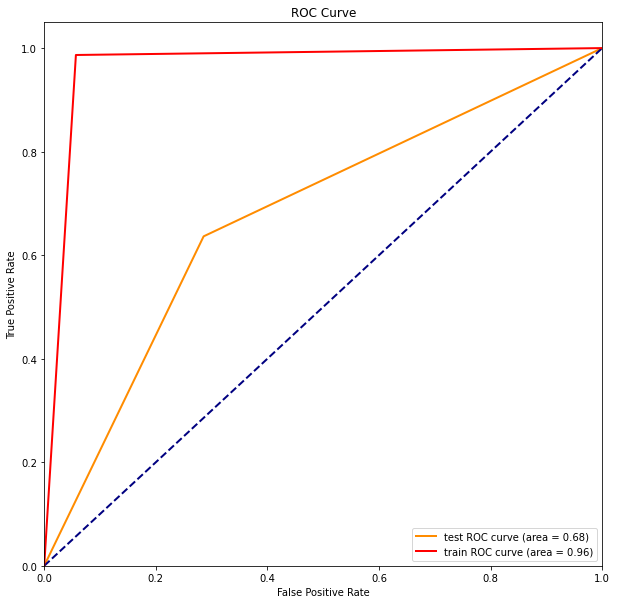


 训练集 0.9631901840490797 测试集 0.6666666666666666
roc: 0.6753246753246753
sensitivity: 0.7142857142857143
specificity: 0.6363636363636364


<Figure size 432x288 with 0 Axes>

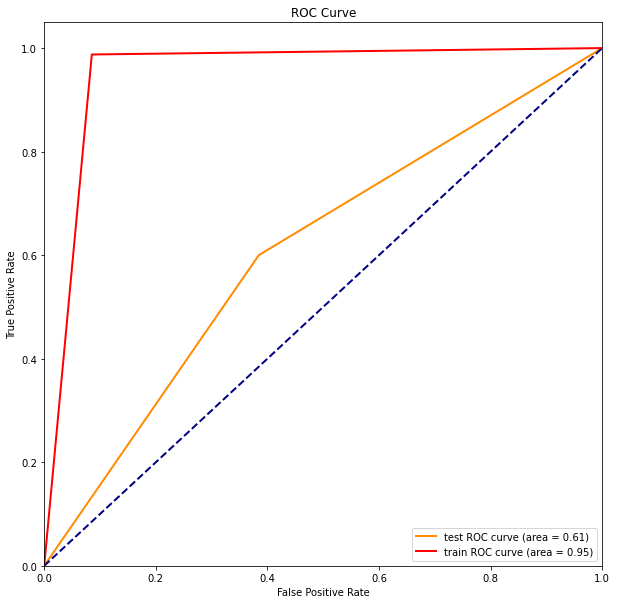


 训练集 0.950920245398773 测试集 0.6111111111111112
roc: 0.6076923076923078
sensitivity: 0.6153846153846154
specificity: 0.6


<Figure size 432x288 with 0 Axes>

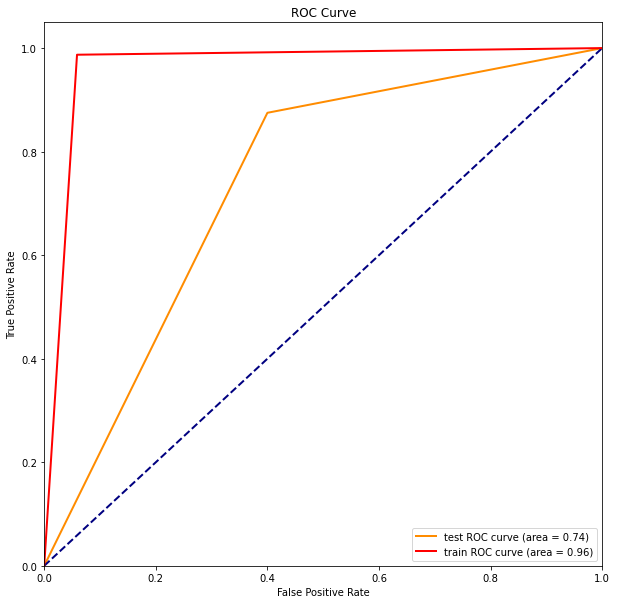


 训练集 0.9631901840490797 测试集 0.7222222222222222
roc: 0.7375
sensitivity: 0.6
specificity: 0.875


<Figure size 432x288 with 0 Axes>

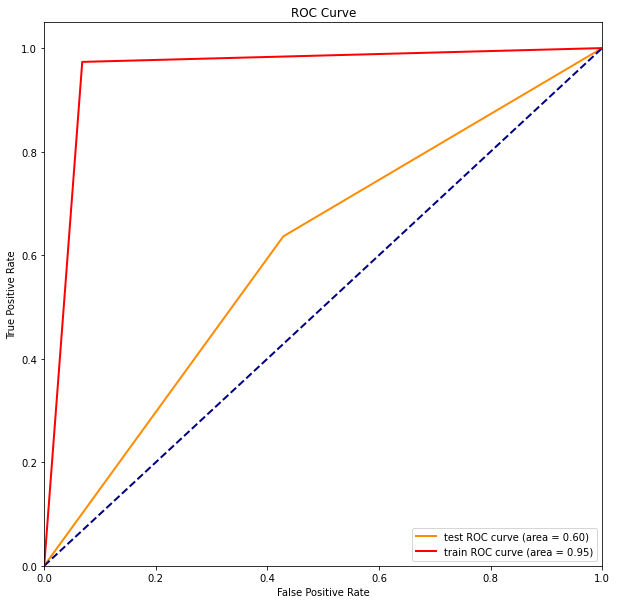


 训练集 0.950920245398773 测试集 0.6111111111111112
roc: 0.6038961038961038
sensitivity: 0.5714285714285714
specificity: 0.6363636363636364


<Figure size 432x288 with 0 Axes>

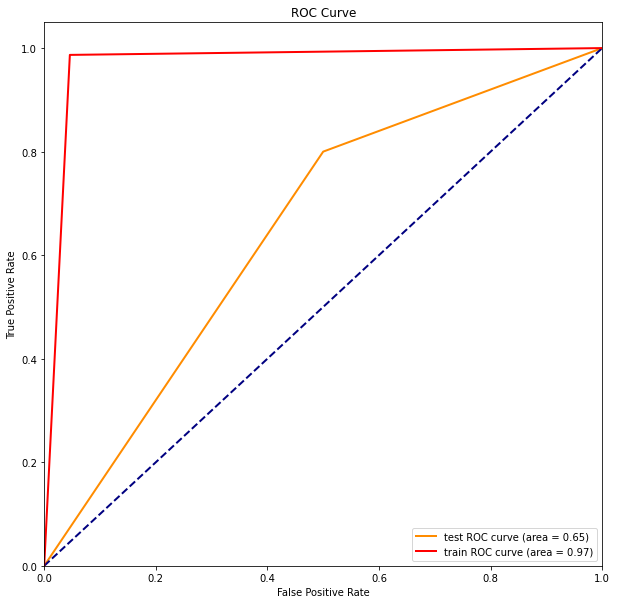


 训练集 0.9693251533742331 测试集 0.6666666666666666
roc: 0.65
sensitivity: 0.5
specificity: 0.8


<Figure size 432x288 with 0 Axes>

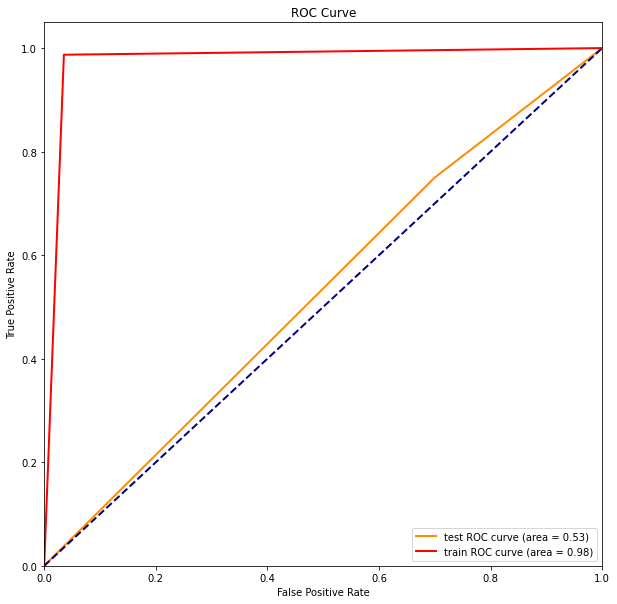


 训练集 0.9754601226993865 测试集 0.5
roc: 0.525
sensitivity: 0.3
specificity: 0.75


<Figure size 432x288 with 0 Axes>

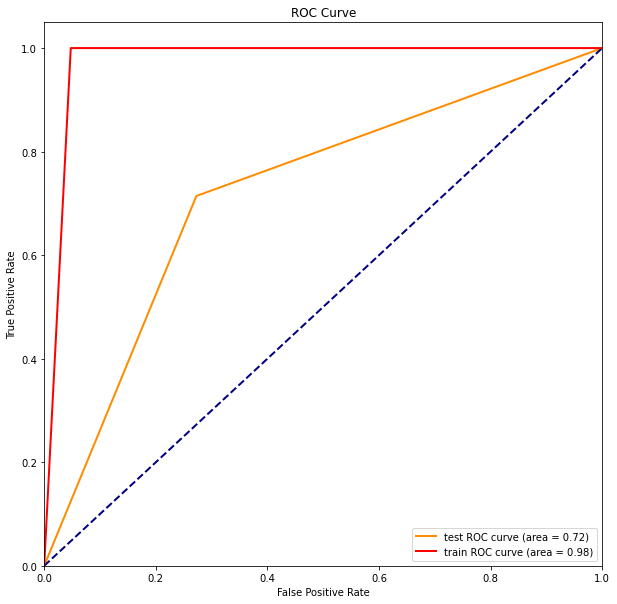


 训练集 0.9754601226993865 测试集 0.7222222222222222
roc: 0.7207792207792209
sensitivity: 0.7272727272727273
specificity: 0.7142857142857143


<Figure size 432x288 with 0 Axes>

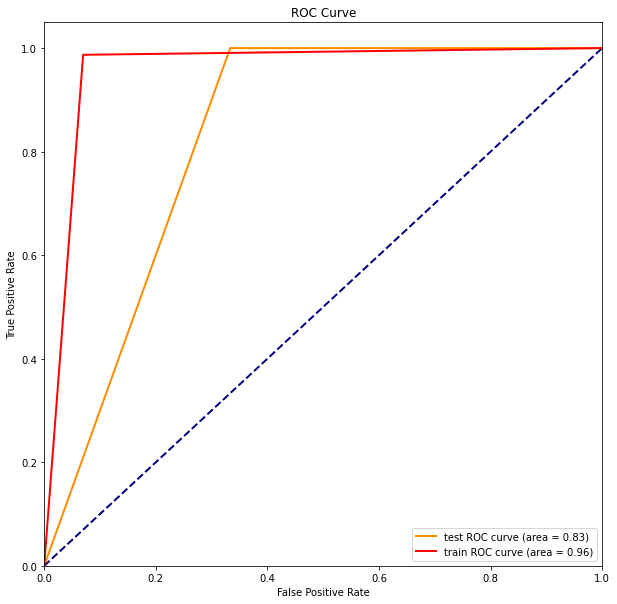


 训练集 0.9570552147239264 测试集 0.8333333333333334
roc: 0.8333333333333334
sensitivity: 0.6666666666666666
specificity: 1.0


<Figure size 432x288 with 0 Axes>

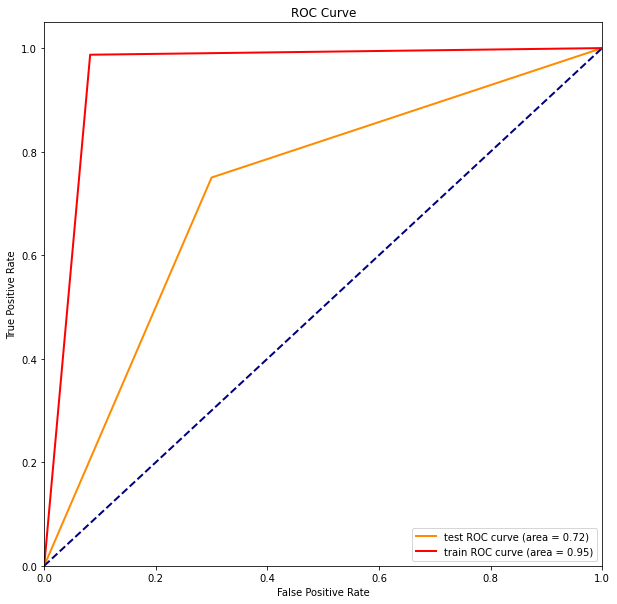


 训练集 0.950920245398773 测试集 0.7222222222222222
roc: 0.7249999999999999
sensitivity: 0.7
specificity: 0.75


<Figure size 432x288 with 0 Axes>

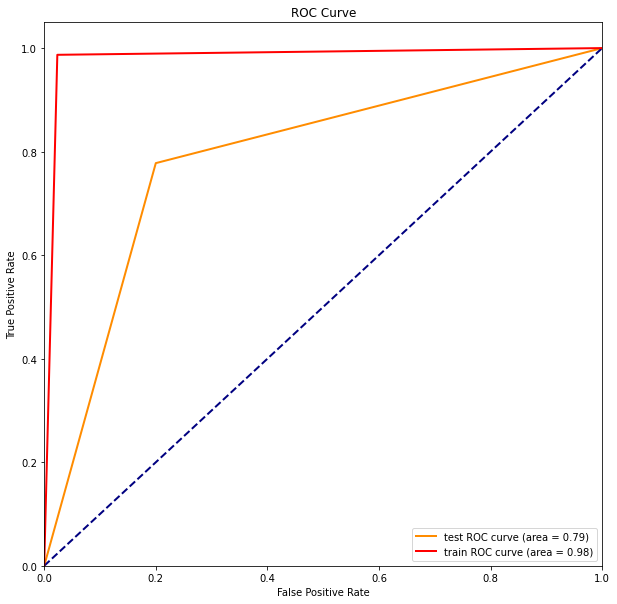


 训练集 0.9814814814814815 测试集 0.7894736842105263
roc: 0.788888888888889
sensitivity: 0.8
specificity: 0.7777777777777778


<Figure size 432x288 with 0 Axes>

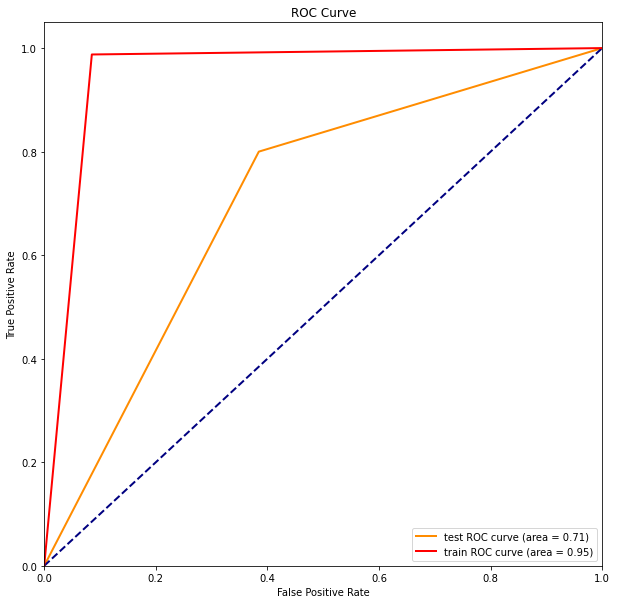


 训练集 0.950920245398773 测试集 0.6666666666666666
roc: 0.7076923076923077
sensitivity: 0.6153846153846154
specificity: 0.8


<Figure size 432x288 with 0 Axes>

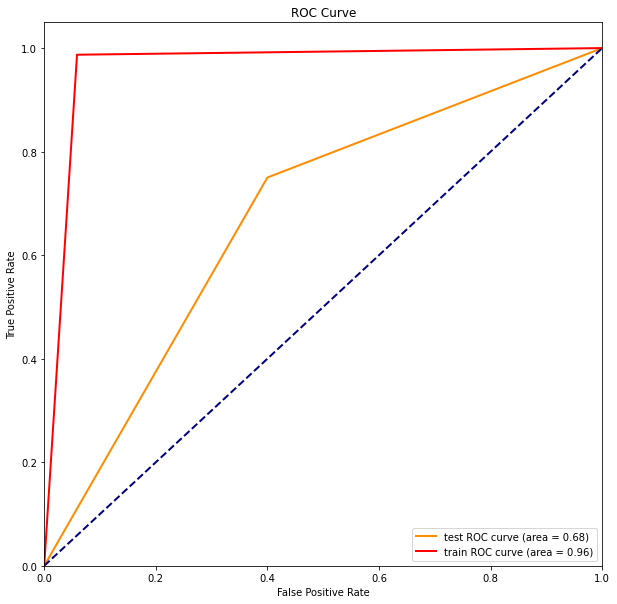


 训练集 0.9631901840490797 测试集 0.6666666666666666
roc: 0.675
sensitivity: 0.6
specificity: 0.75


<Figure size 432x288 with 0 Axes>

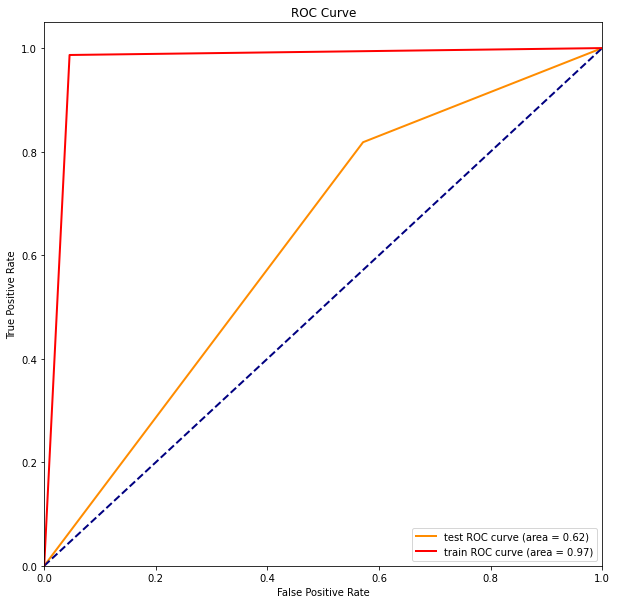


 训练集 0.9693251533742331 测试集 0.6666666666666666
roc: 0.6233766233766235
sensitivity: 0.42857142857142855
specificity: 0.8181818181818182


<Figure size 432x288 with 0 Axes>

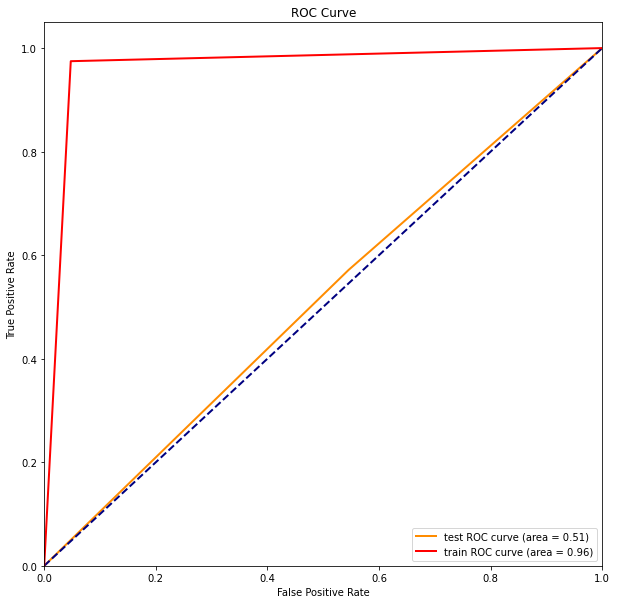


 训练集 0.9631901840490797 测试集 0.5
roc: 0.512987012987013
sensitivity: 0.45454545454545453
specificity: 0.5714285714285714


<Figure size 432x288 with 0 Axes>

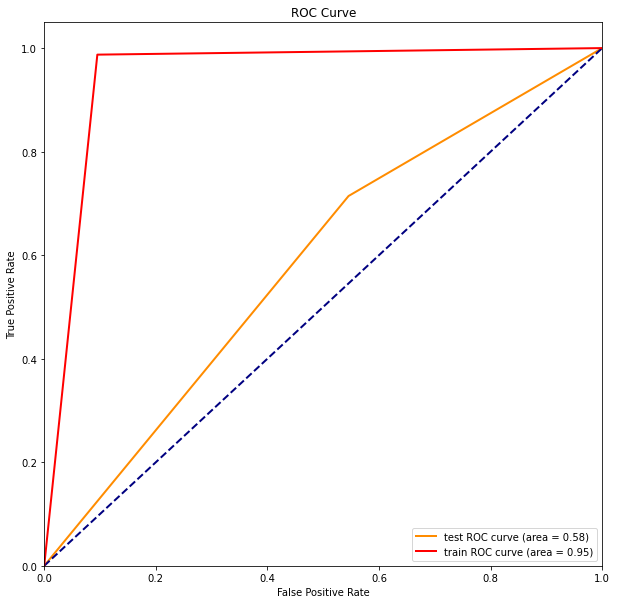


 训练集 0.9447852760736196 测试集 0.5555555555555556
roc: 0.5844155844155845
sensitivity: 0.45454545454545453
specificity: 0.7142857142857143


<Figure size 432x288 with 0 Axes>

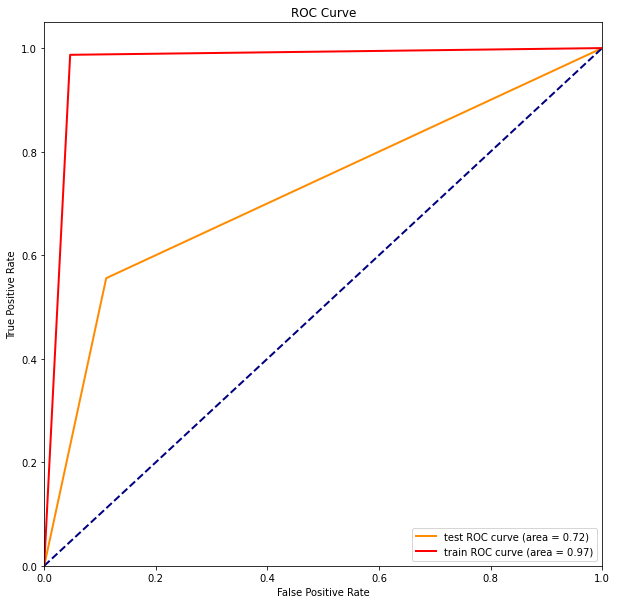


 训练集 0.9693251533742331 测试集 0.7222222222222222
roc: 0.7222222222222222
sensitivity: 0.8888888888888888
specificity: 0.5555555555555556


<Figure size 432x288 with 0 Axes>

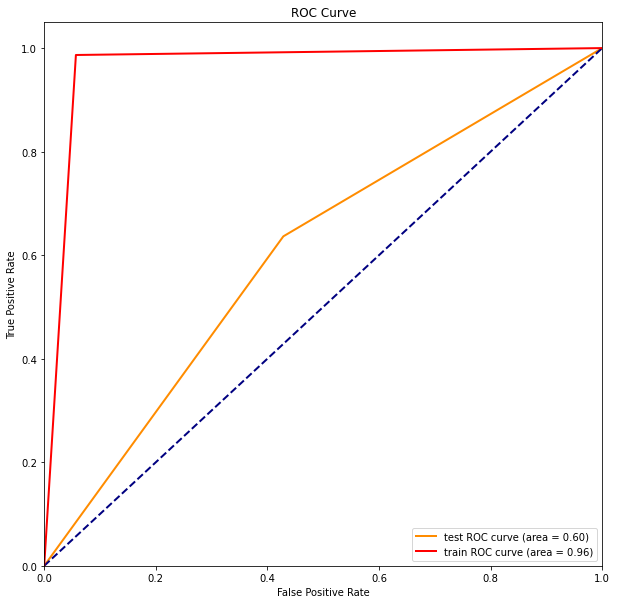


 训练集 0.9631901840490797 测试集 0.6111111111111112
roc: 0.6038961038961038
sensitivity: 0.5714285714285714
specificity: 0.6363636363636364


<Figure size 432x288 with 0 Axes>

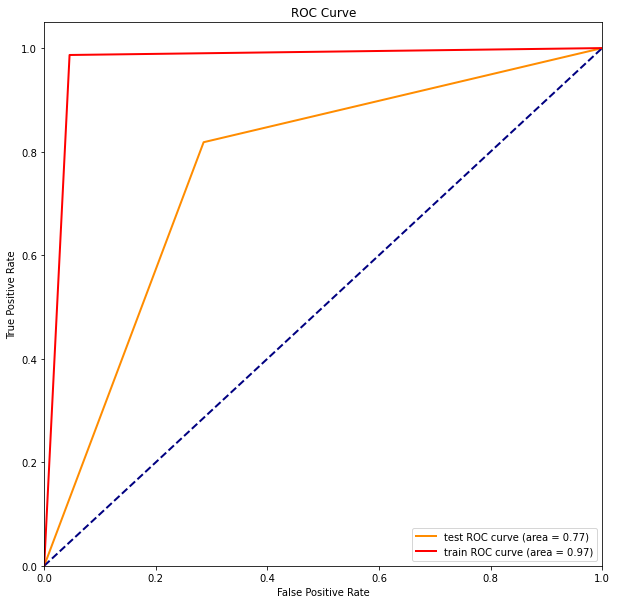


 训练集 0.9693251533742331 测试集 0.7777777777777778
roc: 0.7662337662337664
sensitivity: 0.7142857142857143
specificity: 0.8181818181818182


<Figure size 432x288 with 0 Axes>

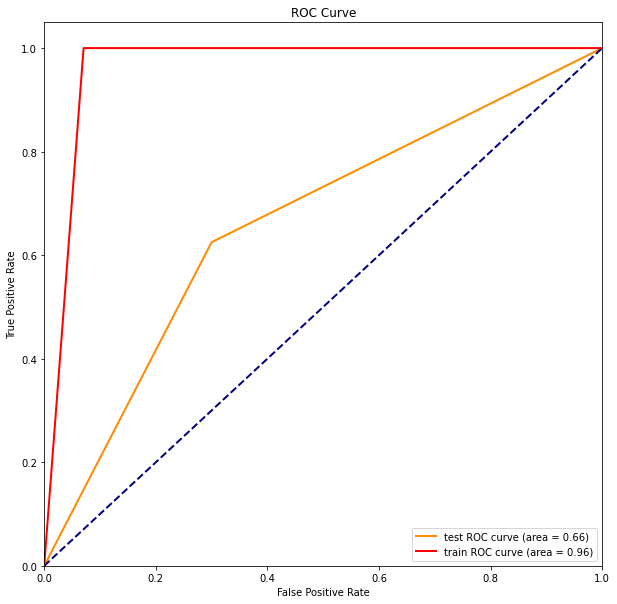


 训练集 0.9631901840490797 测试集 0.6666666666666666
roc: 0.6625
sensitivity: 0.7
specificity: 0.625
average test accuracy: 0.6548830409356725
average train accuracy: 0.9600382488828296
average roc: 0.6618856143856143
average sensitivity: 0.6152170884670884
average specificity: 0.7085541403041402


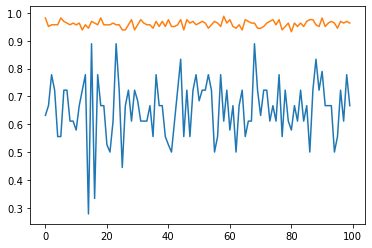

In [47]:
kfold_train_test(10)